In [1]:
%pip install prince -U -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 5.7 MB/s eta 0:00:00


# Análise explorátoria dos dados de treino/teste

https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets

In [2]:
import os
import shutil
import folium
import prince
import tabulate
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

from warnings import filterwarnings
filterwarnings('ignore')

Carregar os dados pré-processados obtidos do repositorio do kaggle

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  # shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_notarget.parquet'  ,'/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Mounted at /content/drive


Carregar os dados de treino e teste

In [4]:
df = pd.concat([pd.read_parquet('./datasets/df_train_test.parquet', engine='pyarrow'), pd.read_parquet('./datasets/df_validation.parquet', engine='pyarrow')])
df.head()

id                date  client_id  card_id  amount           use_chip  \
0  7475327 2010-01-01 00:01:00       1556     2972  -77.00  Swipe Transaction   
1  7475328 2010-01-01 00:02:00        561     4575   14.57  Swipe Transaction   
2  7475329 2010-01-01 00:02:00       1129      102   80.00  Swipe Transaction   
3  7475332 2010-01-01 00:06:00        848     3915   46.41  Swipe Transaction   
4  7475333 2010-01-01 00:07:00       1807      165    4.81  Swipe Transaction   

   merchant_id merchant_city merchant_state      zip  ...        card_type  \
0        59935        Beulah             ND  58523.0  ...  Debit (Prepaid)   
1        67570    Bettendorf             IA  52722.0  ...           Credit   
2        27092         Vista             CA  92084.0  ...            Debit   
3        13051       Harwood             MD  20776.0  ...            Debit   
4        20519         Bronx             NY  10464.0  ...  Debit (Prepaid)   

        card_number  expires  cvv  has_chip  num_cards_issued  credit_limit  \
0  5497590243197280  07/2022  306       YES                 2          55.0   
1  5175842699412235  12/2024  438       YES                 1        9100.0   
2  5874992802287595  05/2020  256       YES                 1       14802.0   
3  4354185735186651  01/2020  120       YES                 1       19113.0   
4  5207231566469664  03/2014  198       YES                 1          89.0   

   acct_open_date year_pin_last_changed card_on_dark_web  
0         05/2008                  2008               No  
1         09/2005                  2015               No  
2         01/2006                  2008               No  
3         07/2009                  2014               No  
4         01/2008                  2015               No  

[5 rows x 38 columns]

In [5]:
df['id'] = df['id'].astype(str)
df['client_id'] = df['client_id'].astype(str)
df['card_id'] = df['card_id'].astype(str)
df['merchant_id'] = df['merchant_id'].astype(str)
df['zip'] = df['zip'].astype(str)
df['card_number'] = df['card_number'].astype(str)
df['cvv'] = df['cvv'].astype(str)
df['birth_year'] = df['birth_year'].astype(str)
df['birth_month'] = df['birth_month'].astype(str)


1. **id**: Identificador único da transação.
2. **date**: Data em que a transação foi realizada.
3. **client_id**: Identificador único do cliente.
4. **card_id**: Identificador único do cartão utilizado na transação.
5. **amount**: Valor da transação.
6. **use_chip**: Indicador se a transação foi efetuada com o uso de chip (sim/não).
7. **merchant_id**: Identificador do comerciante onde a transação foi realizada.
8. **merchant_city**: Cidade onde está localizado o comerciante.
9. **merchant_state**: Estado onde está localizado o comerciante.
10. **zip**: Código postal do local do comerciante.
11. **mcc**: Código de Categoria do Comerciante, que indica o tipo de negócio ou setor do comerciante.
12. **errors**: Indicador de erros ocorridos durante a transação.
13. **description**: Descrição ou comentário associado à transação.
14. **target**: Indicador se a transação foi fraudulenta (Yes) ou não (No).
15. **current_age**: Idade atual do cliente.
16. **retirement_age**: Idade de aposentadoria do cliente.
17. **birth_year**: Ano de nascimento do cliente.
18. **birth_month**: Mês de nascimento do cliente.
19. **gender**: Gênero do cliente.
20. **address**: Endereço residencial do cliente.
21. **latitude**: Latitude do endereço do cliente.
22. **longitude**: Longitude do endereço do cliente.
23. **per_capita_income**: Renda per capita do cliente ou região.
24. **yearly_income**: Renda anual do cliente.
25. **total_debt**: Dívida total do cliente.
26. **credit_score**: Pontuação de crédito do cliente.
27. **num_credit_cards**: Número de cartões de crédito que o cliente possui.
28. **card_brand**: Bandeira do cartão utilizado na transação (Visa, Mastercard, etc.).
29. **card_type**: Tipo do cartão (crédito, débito, etc.).
30. **card_number**: Número do cartão utilizado na transação.
31. **expires**: Data de expiração do cartão.
32. **cvv**: Código de segurança do cartão.
33. **has_chip**: Indicador se o cartão possui chip (sim/não).
34. **num_cards_issued**: Número de cartões emitidos para o cliente.
35. **credit_limit**: Limite de crédito do cartão.
36. **acct_open_date**: Data de abertura da conta do cliente.
37. **year_pin_last_cha**: Ano da última alteração do PIN do cartão.
38. **card_on_dark_web**: Indicador se o cartão foi encontrado em listas de venda na dark web.

In [6]:
def get_outliers(df, column, min_zero = True):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  if min_zero:
    lower_bound = lower_bound if lower_bound >= 0 else 0
  upper_bound = Q3 + 1.5 * IQR
  if min_zero:
    upper_bound = upper_bound if upper_bound >= 0 else 0

  return lower_bound, upper_bound

In [7]:
def plot_hist_box(df_, var):
  data = df[var]

  fig = plt.figure(figsize=(15,4))
  ax1 = fig.add_subplot(1, 3, 1)
  ax1.set_title('Histograma')
  sns.histplot(data, kde=True, ax = ax1)
  ax1.set_xlabel(var)
  ax1.tick_params(axis='x', rotation=90)
  ax1.set_ylabel('Frequência')

  ax2 = fig.add_subplot(1, 3, 2)
  ax2.set_title('Boxplot')
  sns.boxplot(data, ax=ax2)
  ax2.set_ylabel('Frequência')

  ax3 = fig.add_subplot(1, 3, 3)
  ax3.set_title('QQ-plot')
  sm.qqplot(data, line='s', ax=ax3)

  plt.suptitle(f'{var}')
  plt.tight_layout()
  plt.show()

In [8]:
def descritiva(df_, var, vresp: str, max_classes=5, map_target: dict|None = None):
    df = df_[[var, vresp]].copy()

    if df[var].dtype in [np.float64, np.int64]:
      if df[var].nunique()>max_classes:
          df[var] = pd.qcut(df[var], max_classes, duplicates='drop')

    if map_target is not None:
      df[vresp] = df[vresp].map(map_target)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1 = sns.countplot(data=df, x=var, palette='viridis', alpha=0.5, ax=ax1)
    ax1.set_ylabel('Frequência', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    for p in ax1.patches:
        ax1.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    ax2 = ax1.twinx()

    sns.pointplot(data=df, y=vresp, x=var, ax=ax2)
    ax2.set_ylabel(vresp, color='red')

    ax1.set_zorder(2)
    ax1.patch.set_visible(False)  # Tornar o fundo do eixo 1 transparente

    # Exibir o gráfico
    plt.show()
    del df

## Análise Temporal

Vamos analisar os dados com base na caracteristica tempo a fim de entender as caracteristicas das transações

### Análise diaria

In [9]:
df_time_day = pd.DataFrame()
df_time_day['day'] = df['date'].dt.to_period('D')
df_time_day['target'] = df['target'].apply(lambda x: 1 if x == 'Yes' else 0)
df_time_day['amount'] = df['amount']
df_time_day.head()

day  target  amount
0  2010-01-01       0  -77.00
1  2010-01-01       0   14.57
2  2010-01-01       0   80.00
3  2010-01-01       0   46.41
4  2010-01-01       0    4.81

In [10]:
df_transactions_day = df_time_day.groupby(by='day').agg({'amount': ['sum', 'count'], 'target': 'sum'}).reset_index()
df_transactions_day.columns = ['day', 'amount', 'transactions', 'total_frauds']
df_transactions_day['mean_amount'] = (df_transactions_day['amount'] / df_transactions_day['transactions']).round(2)
df_transactions_day['has_fraud'] = df_transactions_day['total_frauds'] > 0
df_transactions_day.head()

day     amount  transactions  total_frauds  mean_amount  has_fraud
0  2010-01-01   80720.21          2329             1        34.66       True
1  2010-01-02   93346.82          1971             0        47.36      False
2  2010-01-03   93505.91          2201             1        42.48       True
3  2010-01-04   91449.68          2216             2        41.27       True
4  2010-01-05  100216.52          2269             1        44.17       True

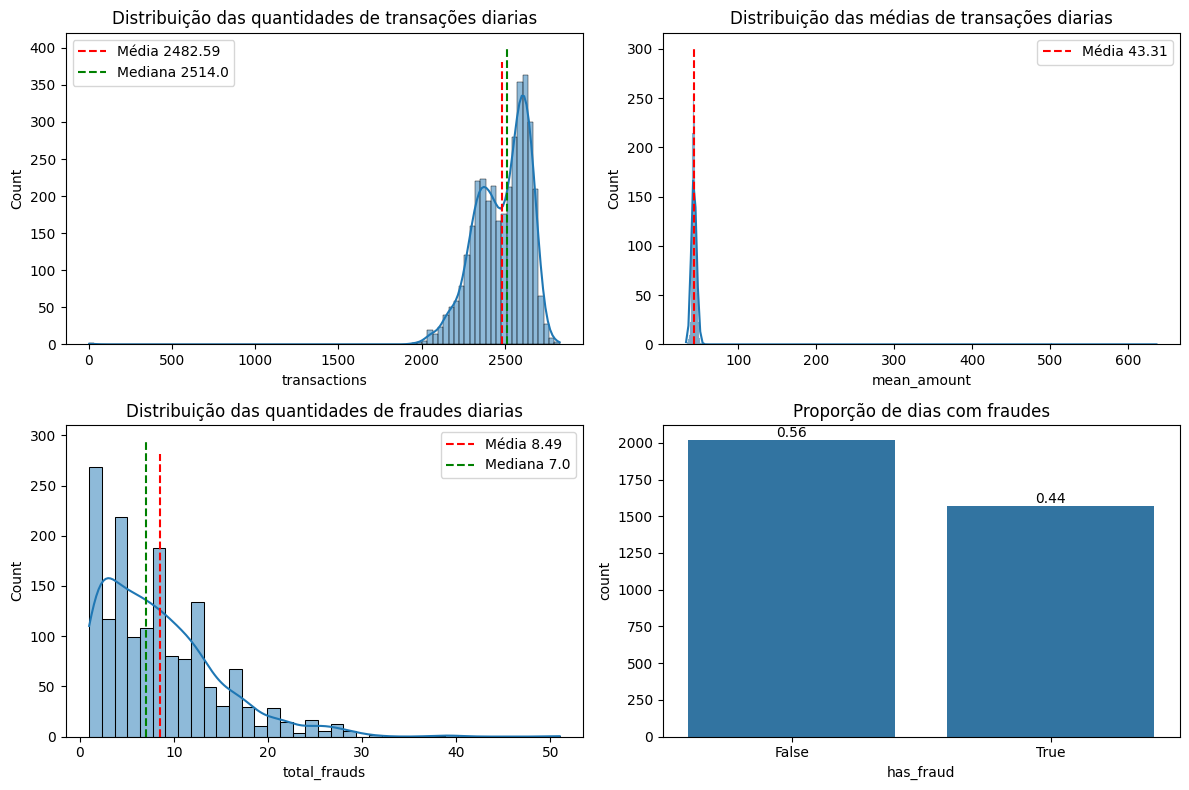

In [11]:
plt.figure(figsize=(12, 8))
plt.subplot(221)

plt.title('Distribuição das quantidades de transações diarias')
ax = sns.histplot(df_transactions_day['transactions'], kde=True)
ax.vlines(df_transactions_day['transactions'].mean(), 0, ax.get_ylim()[1], color='red', linestyles='dashed', label=f'Média {round(df_transactions_day["transactions"].mean(), 2)}')
ax.vlines(df_transactions_day['transactions'].median(), 0, ax.get_ylim()[1], color='green', linestyles='dashed', label=f'Mediana {round(df_transactions_day["transactions"].median(), 2)}')
ax.legend()

plt.subplot(222)
plt.title('Distribuição das médias de transações diarias')
ax = sns.histplot(df_transactions_day['mean_amount'], kde=True)
ax.vlines(df_transactions_day['mean_amount'].mean(), 0, ax.get_ylim()[1], color='red', linestyles='dashed', label=f'Média {round(df_transactions_day["mean_amount"].mean(), 2)}' )
ax.legend()

plt.subplot(223)
plt.title('Distribuição das quantidades de fraudes diarias')
ax = sns.histplot(df_transactions_day.query('total_frauds > 0')['total_frauds'], kde=True)
ax.vlines(df_transactions_day.query('total_frauds > 0')['total_frauds'].mean(), 0, ax.get_ylim()[1], color='red', linestyles='dashed', label=f'Média {round(df_transactions_day.query("total_frauds > 0")["total_frauds"].mean(), 2)}')
ax.vlines(df_transactions_day.query('total_frauds > 0')['total_frauds'].median(), 0, ax.get_ylim()[1], color='green', linestyles='dashed', label=f'Mediana {round(df_transactions_day.query("total_frauds > 0")["total_frauds"].median(), 2)}')
ax.legend()

plt.subplot(224)
plt.title('Proporção de dias com fraudes')
ax = sns.countplot(data=df_transactions_day, x='has_fraud')

total = len(df_transactions_day)
for path in ax.patches:
  ax.annotate(f'{path.get_height()/total:.2f}', (path.get_x() + path.get_width() / 2., path.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

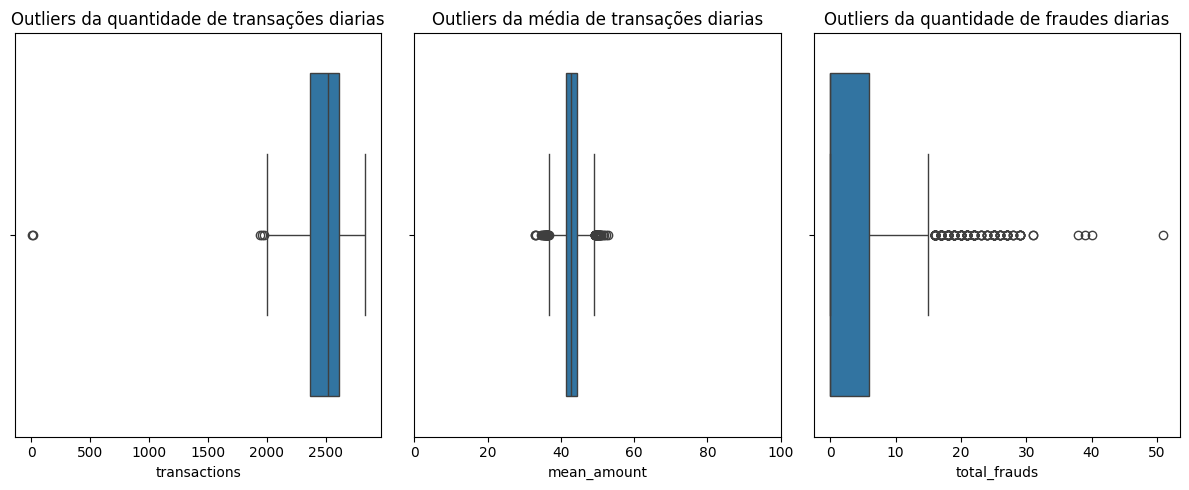

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(131)
plt.title('Outliers da quantidade de transações diarias')
ax = sns.boxplot(x=df_transactions_day['transactions'])

plt.subplot(132)
plt.title('Outliers da média de transações diarias')
ax = sns.boxplot(x=df_transactions_day['mean_amount'])
ax.set_xlim(0, 100)

plt.subplot(133)
plt.title('Outliers da quantidade de fraudes diarias')
ax = sns.boxplot(x=df_transactions_day['total_frauds'])

plt.tight_layout()
plt.show()

In [13]:
stat, p = stats.shapiro(df_transactions_day['transactions'])

alpha = 0.05

if p > alpha:
    print('A amostra provavelmente segue uma distribuição normal (falha ao rejeitar H0)')
else:
    print('A amostra provavelmente não segue uma distribuição normal (rejeita H0)')

A amostra provavelmente não segue uma distribuição normal (rejeita H0)


In [14]:
min, max = get_outliers(df_transactions_day, 'transactions')
print('Outlier min:', min)
print('Outlier max:', max)

Outlier min: 1998.25
Outlier max: 2980.25


In [15]:
min, max = get_outliers(df_transactions_day, 'mean_amount')
print('Outlier min:', round(min, 2))
print('Outlier max:', round(max, 2))

Outlier min: 36.67
Outlier max: 49.23


In [16]:
min, max = get_outliers(df_transactions_day, 'total_frauds')
print('Outlier min:', round(min, 2))
print('Outlier max:', round(max, 2))

Outlier min: 0
Outlier max: 15.0


Análises

> Quantidade de transações por dia

* A quantidade de transações tem um pico próximo de 2500 transações diárias.
* A média e mediana estão bem próximas, com a média inferior a mediana, indicando uma distribuição assimetrica a esquerda (assimetria negativa).
* A distribuição não segue uma distribuição normal.
* Ha uma concentração muito grande de dias com quantidades entre 1996 e 2956.
* Dias com quantidade de transações menores que 2000 são consideradas outliers em relação ao comportamento da variável.

> Valor médio das transações

* A média das transações é de 43.42
* Existem transações com valores muito maiores acima da média (acima de 600).
* Transações com valores abaixo de 36.67 e acima de 49.34 são considerados outliers.

> Fraudes

* A quantidade média de fraudes por dia, quando ocorre, é de 8.79 e mediana é 7.
* Dias com quantidade de fraude acima de 12.5 são outliers
* 40% dos dias tiveram fraude.

### Análise Mensal

In [17]:
df_time = pd.DataFrame()
df_time['year'] = df['date'].dt.to_period('Y')
df_time['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp(how='start')
df_time['amount'] = df['amount']
df_time['target'] = df['target']
df_time.head()

year year_month  amount target
0  2010 2010-01-01  -77.00     No
1  2010 2010-01-01   14.57     No
2  2010 2010-01-01   80.00     No
3  2010 2010-01-01   46.41     No
4  2010 2010-01-01    4.81     No

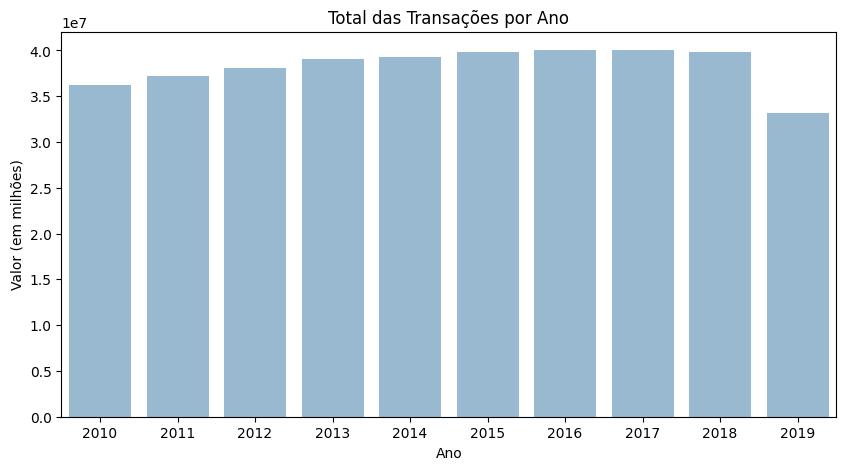

In [18]:
df_time_year = df_time.groupby(['year'])['amount'].sum().reset_index()

plt.subplots(figsize=(10, 5))
plt.title('Total das Transações por Ano')
sns.barplot(data=df_time_year, x='year', y='amount', alpha=0.5)
plt.ylabel('Valor (em milhões)')
plt.xlabel('Ano')

plt.show()

In [19]:
df_time_year = df_time.groupby(['year','target'])['amount'].sum().reset_index()
df_time_year['amount_million'] = df_time_year['amount'] / 1000000
df_time_year.head()

year target       amount  amount_million
0  2010     No  35918813.06       35.918813
1  2010    Yes    307936.83        0.307937
2  2011     No  37251408.65       37.251409
3  2011    Yes      4745.40        0.004745
4  2012     No  38004741.12       38.004741

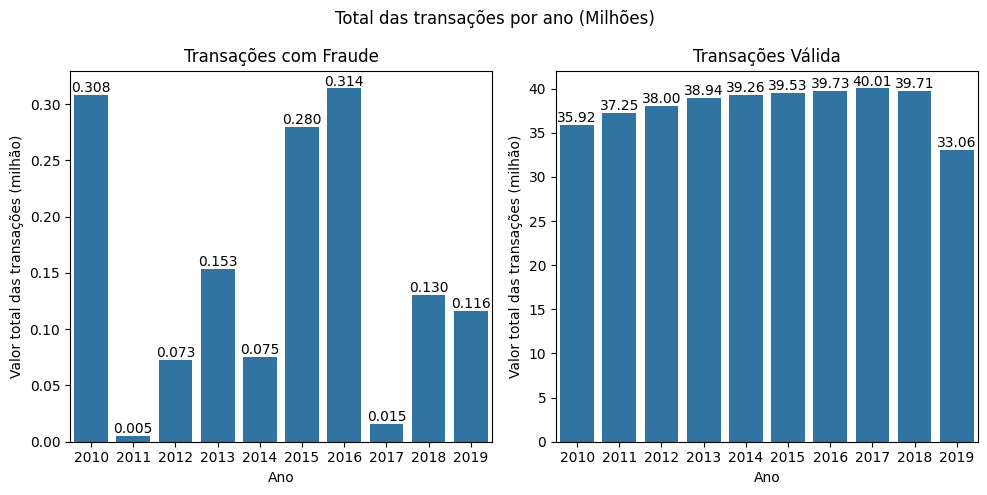

In [20]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Transações com Fraude')
ax1 = sns.barplot(data=df_time_year.query('target == "Yes"'), x='year', y='amount_million')
for patches in ax1.patches:
    ax1.annotate(f'{patches.get_height():.3f}', (patches.get_x() + patches.get_width() / 2., patches.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.ylabel('Valor total das transações (milhão)')
plt.xlabel('Ano')

plt.subplot(122)
plt.title('Transações Válida')
ax2 = sns.barplot(data=df_time_year.query('target == "No"'), x='year', y='amount_million')
for patches in ax2.patches:
    ax2.annotate(f'{patches.get_height():.2f}', (patches.get_x() + patches.get_width() / 2., patches.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.ylabel('Valor total das transações (milhão)')
plt.xlabel('Ano')

plt.suptitle('Total das transações por ano (Milhões)')
plt.tight_layout()
plt.show()

del df_time_year

In [21]:
df_time_month = df_time.groupby(by=['year_month', 'target'])['amount'].agg(['sum', 'mean', 'std']).reset_index()
df_time_month['year'] = df_time_month['year_month'].dt.year
df_time_month['month'] = df_time_month['year_month'].dt.month
df_time_month['amount_million'] = df_time_month['sum'] / 1000000
df_time_month.head()

year_month target         sum        mean         std  year  month  \
0 2010-01-01     No  2929129.96   43.115386   82.574700  2010      1   
1 2010-01-01    Yes    12253.57  114.519346  203.905324  2010      1   
2 2010-02-01     No  2713507.09   43.376554   82.612872  2010      2   
3 2010-02-01    Yes    32488.11  125.436718  305.307738  2010      2   
4 2010-03-01     No  2984733.64   43.294029   83.392894  2010      3   

   amount_million  
0        2.929130  
1        0.012254  
2        2.713507  
3        0.032488  
4        2.984734

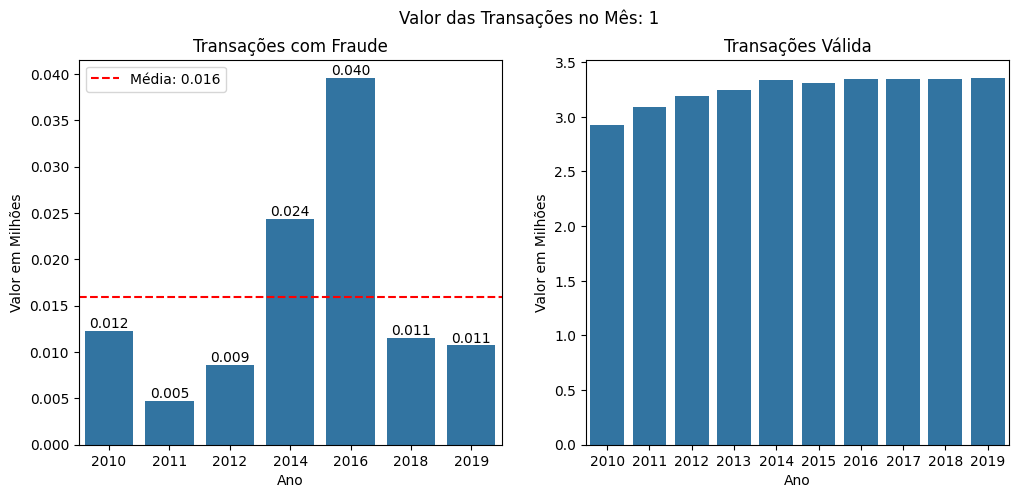

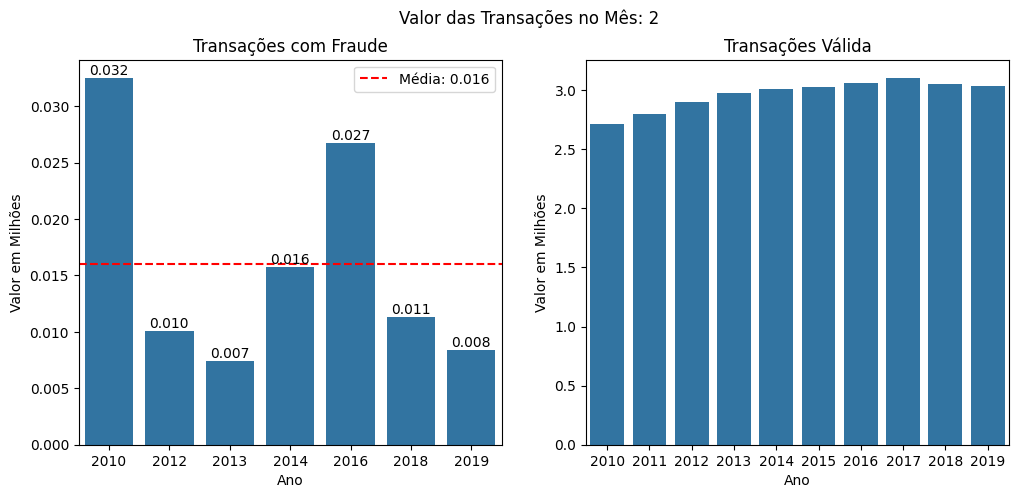

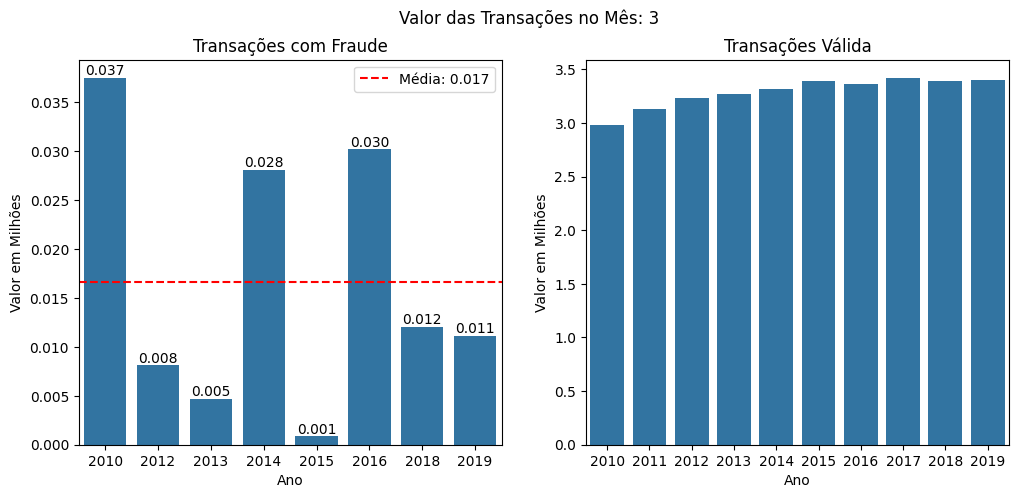

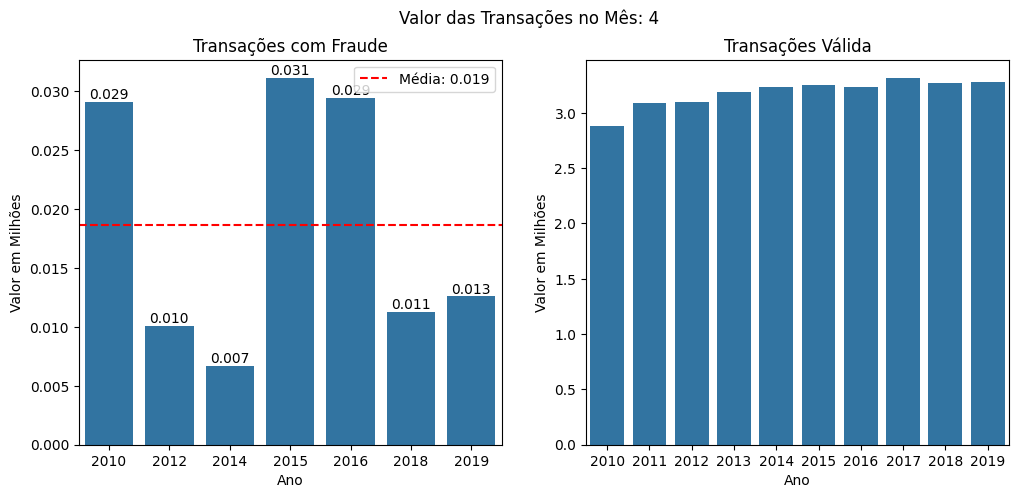

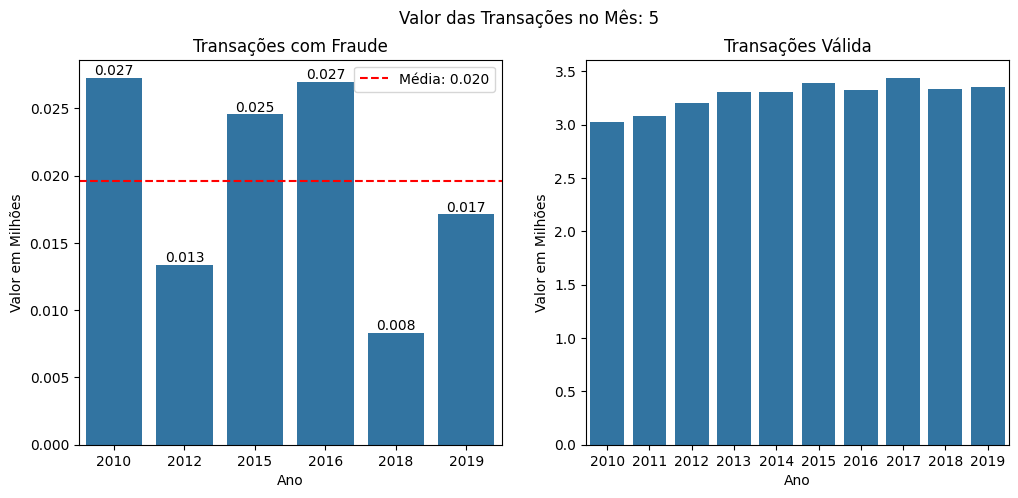

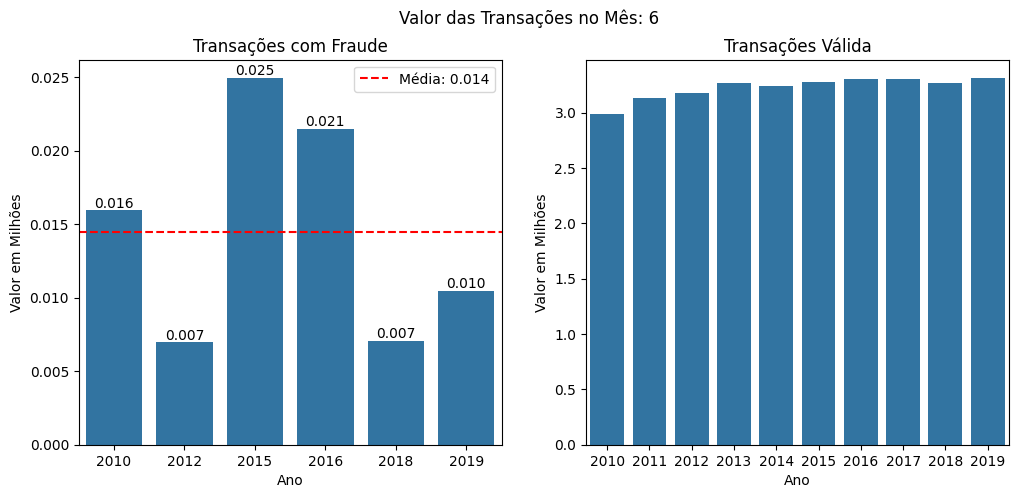

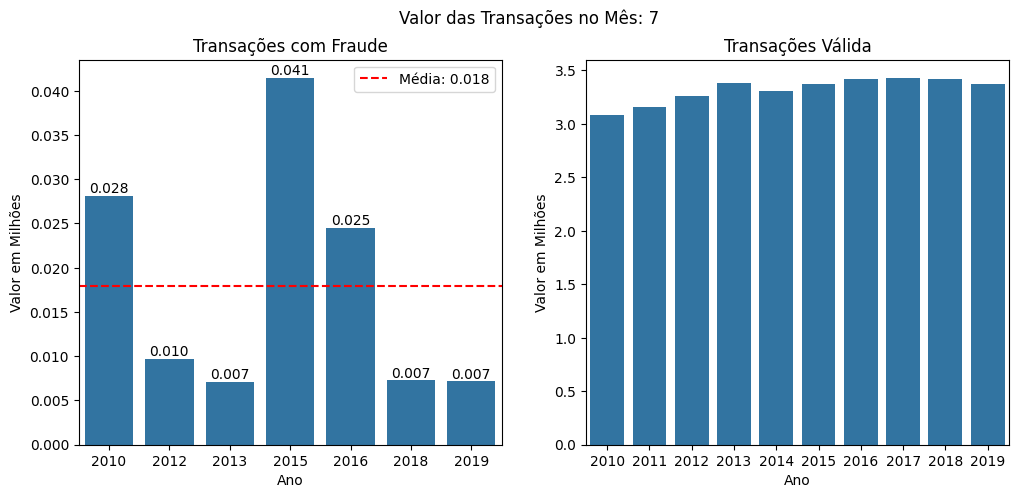

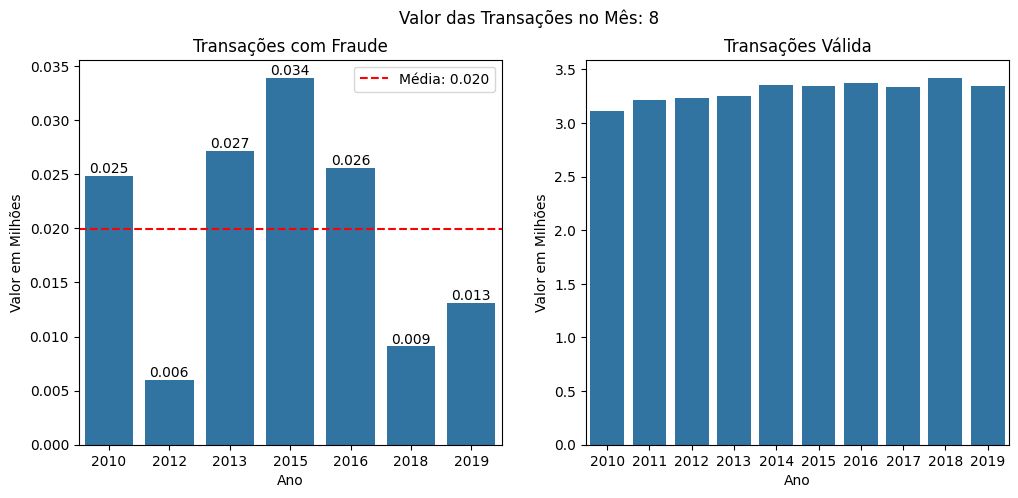

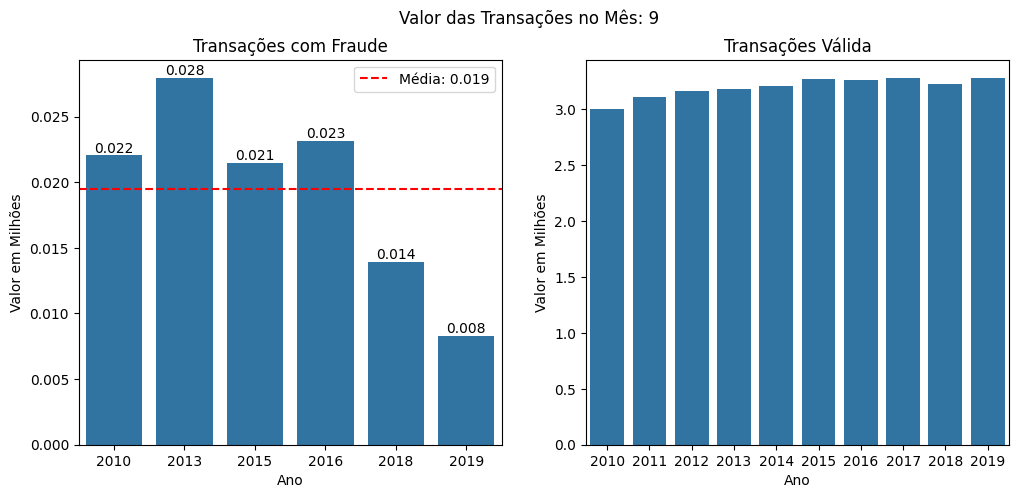

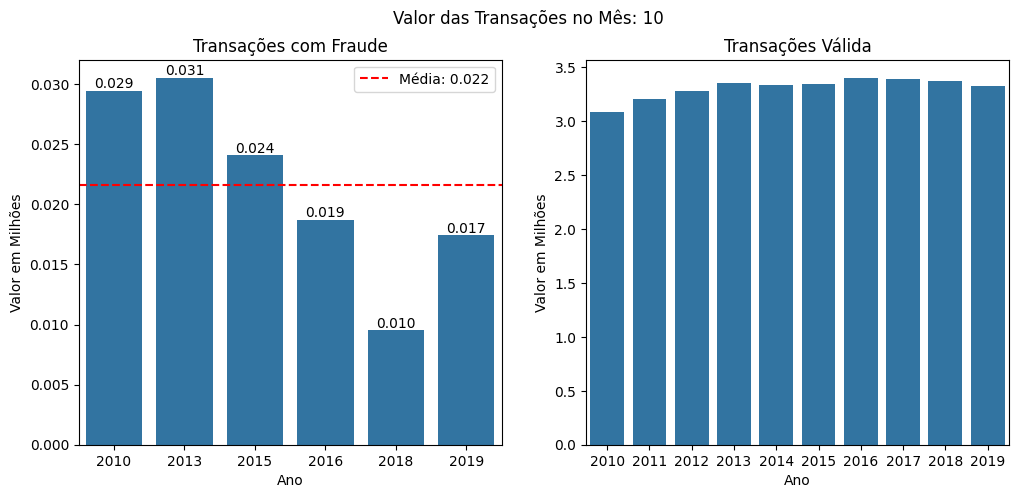

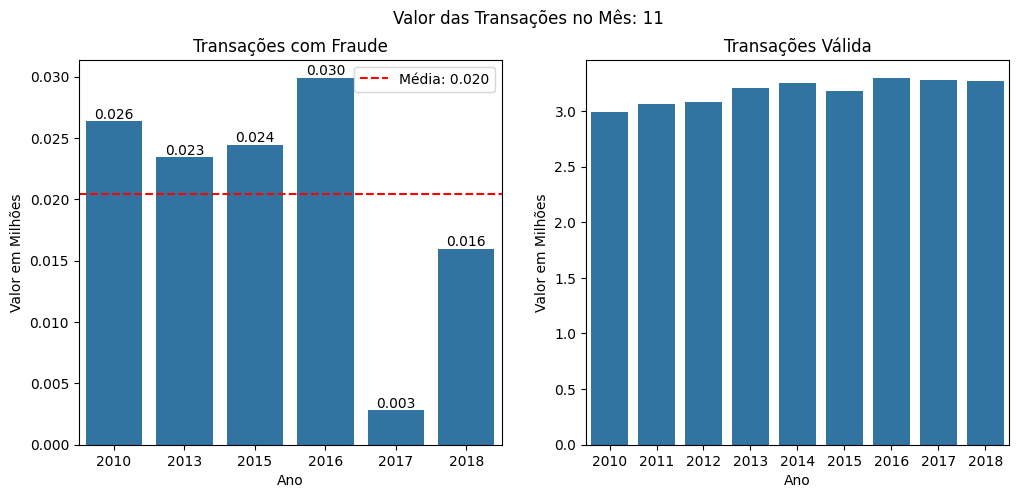

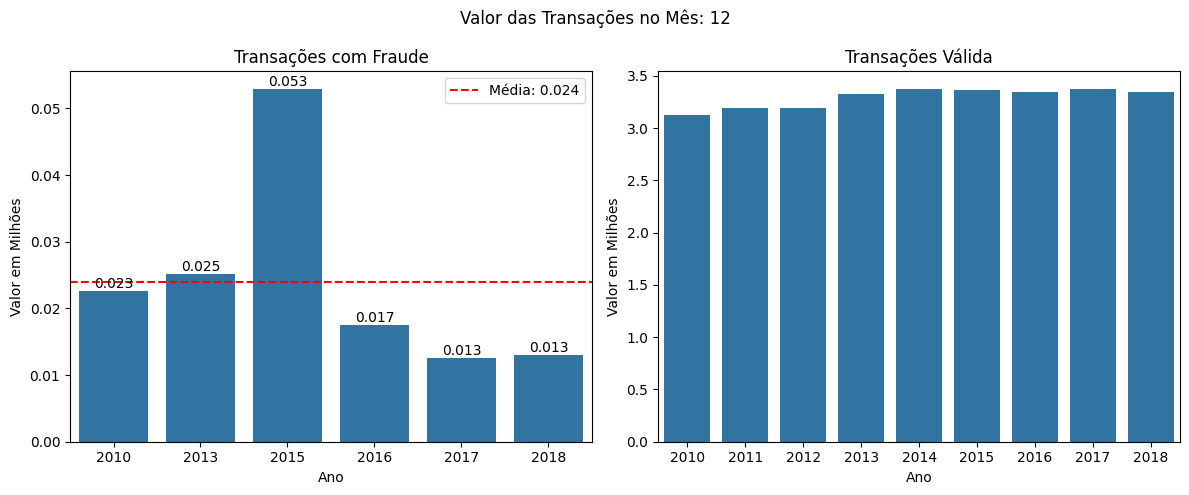

In [22]:
for month in df_time_month['month'].unique():
  df_time_month_month = df_time_month.query('month == @month')

  plt.figure(figsize=(12,5))
  plt.suptitle(f'Valor das Transações no Mês: {month}')

  plt.subplot(121)
  plt.title('Transações com Fraude')

  ax = sns.barplot(data=df_time_month_month.query('target == "Yes"'), x='year', y='amount_million')

  for patches in ax.patches:
    ax.annotate(f'{patches.get_height():.3f}', (patches.get_x() + patches.get_width() / 2., patches.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

  mean = df_time_month_month.query('target == "Yes"')['amount_million'].mean()
  ax.axhline(mean, color='red', linestyle='--', label=f'Média: {mean:.3f}')
  ax.legend()

  plt.ylabel('Valor em Milhões')
  plt.xlabel('Ano')

  plt.subplot(122)
  plt.title('Transações Válida')
  sns.barplot(data=df_time_month_month.query('target == "No"'), x='year', y='amount_million')
  plt.ylabel('Valor em Milhões')
  plt.xlabel('Ano')

plt.tight_layout()
plt.show()

* Outubro e Dezembro são os meses com maior média de prejuizo nos anos avaliados (26 mil aproximadamente).
* 2016 foi o ano com maior quantidade e proporção de fraude.

In [23]:
del df_time, df_time_day, df_time_month, df_time_month_month, df_transactions_day

## Análise Numérica

In [24]:
number_columns = df.select_dtypes(include=['float64', 'int64']).columns
number_columns

Index(['amount', 'current_age', 'retirement_age', 'latitude', 'longitude',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'num_cards_issued', 'credit_limit',
       'year_pin_last_changed'],
      dtype='object')

In [25]:
df[number_columns].describe()

amount   current_age  retirement_age      latitude     longitude  \
count  8.914963e+06  8.914963e+06    8.914963e+06  8.914963e+06  8.914963e+06   
mean   4.294939e+01  5.402147e+01    6.648777e+01  3.737615e+01 -9.156999e+01   
std    8.152652e+01  1.572477e+01    3.587085e+00  5.091677e+00  1.626130e+01   
min   -5.000000e+02  2.300000e+01    5.300000e+01  2.130000e+01 -1.581800e+02   
25%    8.930000e+00  4.200000e+01    6.500000e+01  3.389000e+01 -9.737000e+01   
50%    2.899000e+01  5.200000e+01    6.600000e+01  3.835000e+01 -8.647000e+01   
75%    6.368000e+01  6.300000e+01    6.800000e+01  4.112000e+01 -8.012000e+01   
max    6.613440e+03  1.010000e+02    7.900000e+01  4.853000e+01 -6.867000e+01   

       per_capita_income  yearly_income    total_debt  credit_score  \
count       8.914963e+06   8.914963e+06  8.914963e+06  8.914963e+06   
mean        2.398357e+04   4.669135e+04  5.802153e+04  7.139262e+02   
std         1.197540e+04   2.445588e+04  5.209717e+04  6.581489e+01   
min         0.000000e+00   1.000000e+00  0.000000e+00  4.880000e+02   
25%         1.711300e+04   3.281700e+04  1.643700e+04  6.840000e+02   
50%         2.115600e+04   4.109100e+04  5.167900e+04  7.160000e+02   
75%         2.730800e+04   5.401300e+04  8.516000e+04  7.560000e+02   
max         1.631450e+05   2.801990e+05  4.618540e+05  8.500000e+02   

       num_credit_cards  num_cards_issued  credit_limit  year_pin_last_changed  
count      8.914963e+06      8.914963e+06  8.914963e+06           8.914963e+06  
mean       3.841198e+00      1.522064e+00  1.554959e+04           2.011340e+03  
std        1.567701e+00      5.151711e-01  1.218199e+04           2.894518e+00  
min        1.000000e+00      1.000000e+00  0.000000e+00           2.002000e+03  
25%        3.000000e+00      1.000000e+00  8.100000e+03           2.010000e+03  
50%        4.000000e+00      2.000000e+00  1.345500e+04           2.011000e+03  
75%        5.000000e+00      2.000000e+00  2.083900e+04           2.013000e+03  
max        9.000000e+00      3.000000e+00  1.413910e+05           2.020000e+03

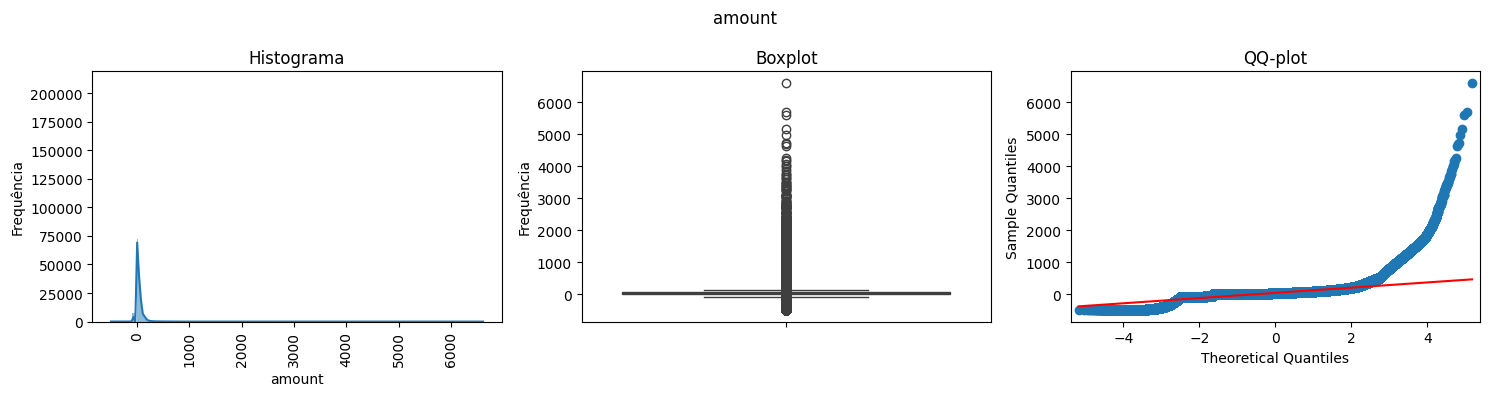

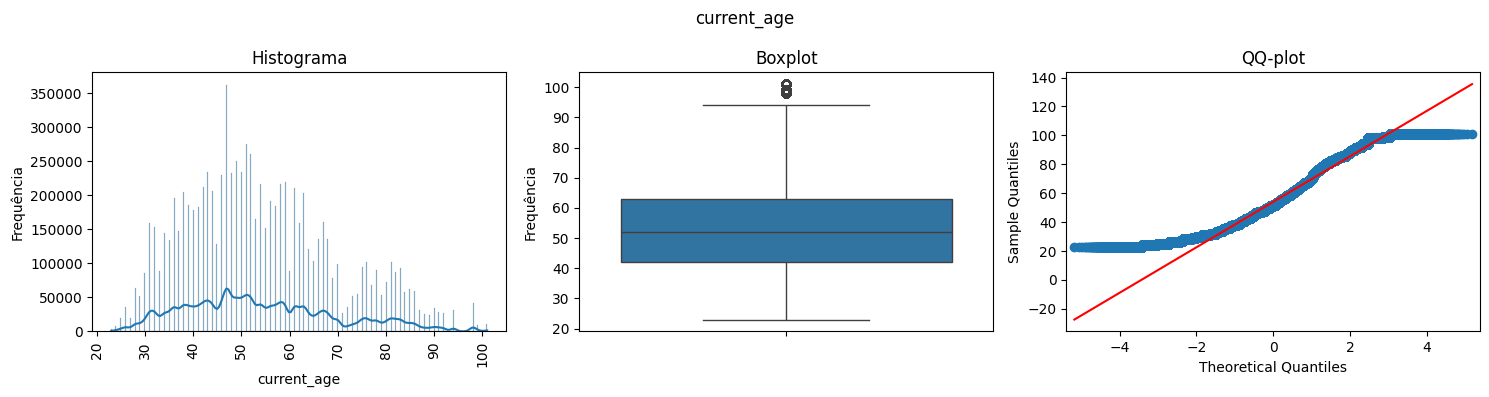

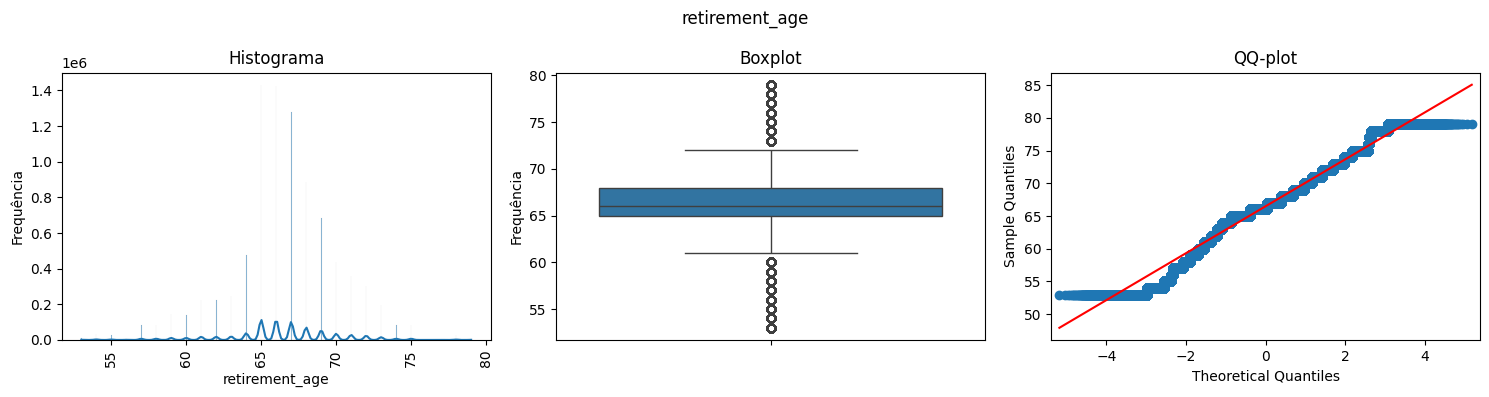

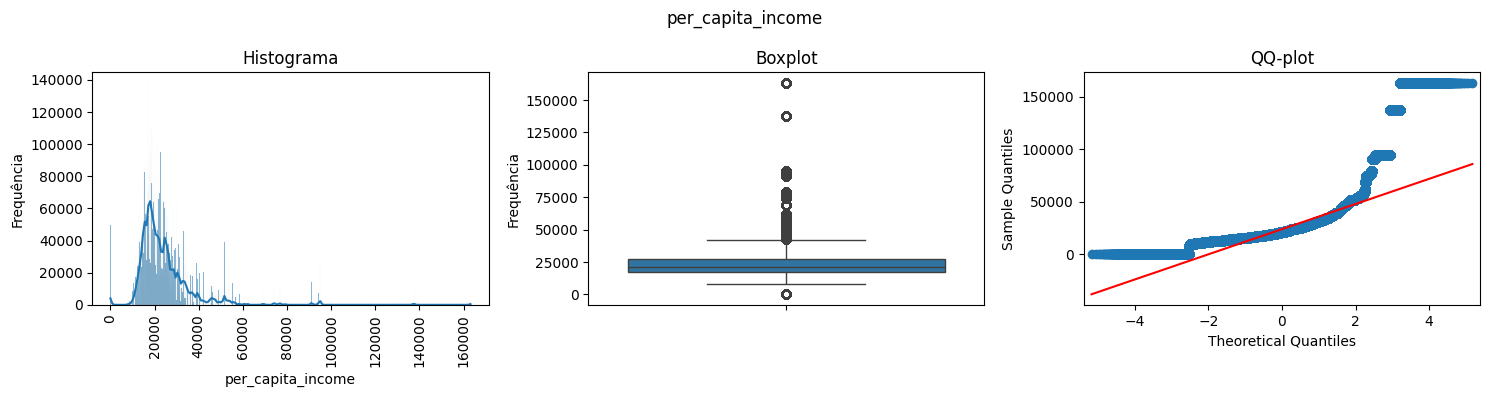

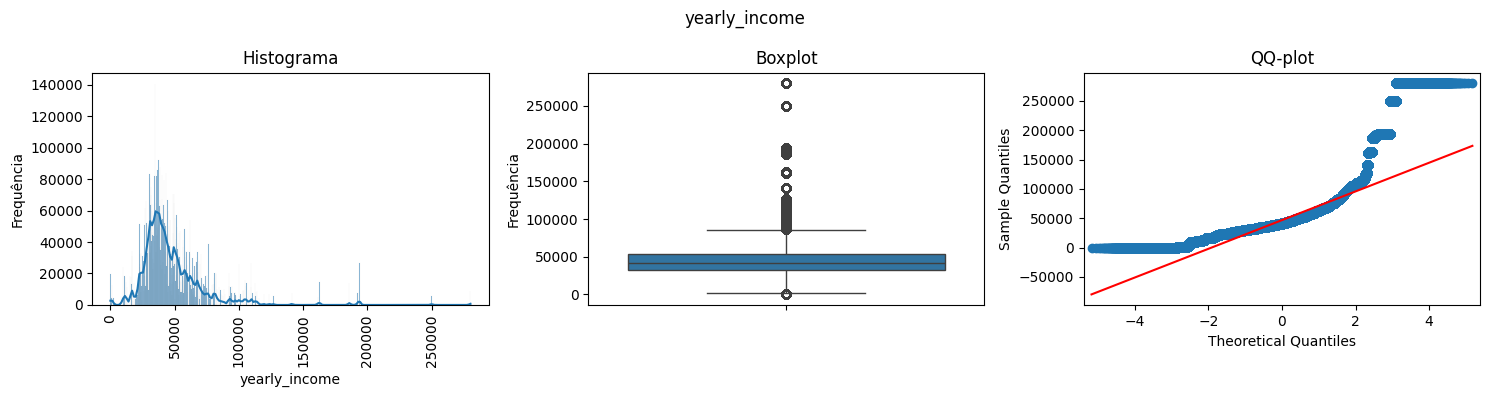

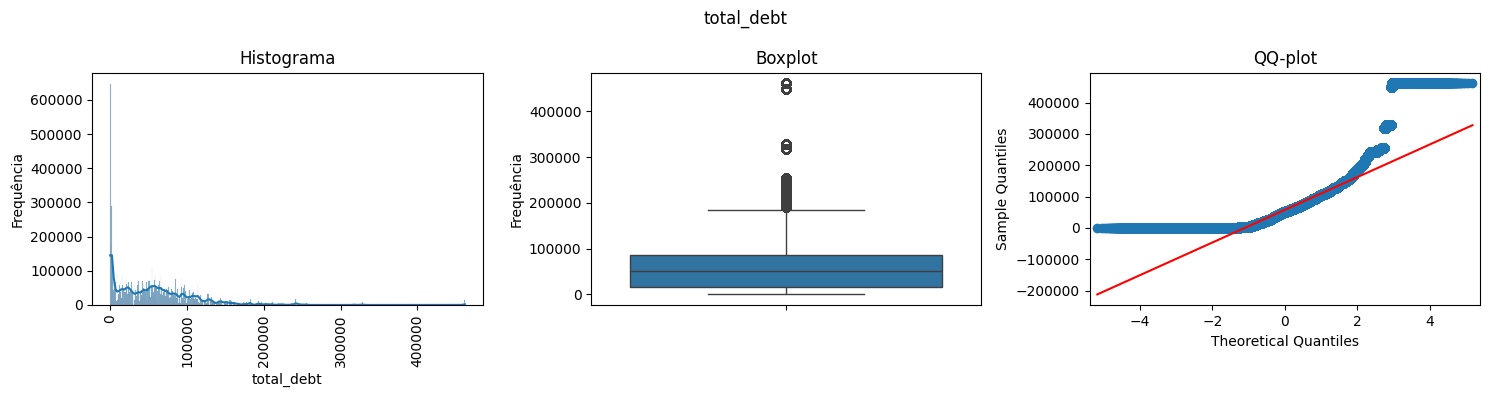

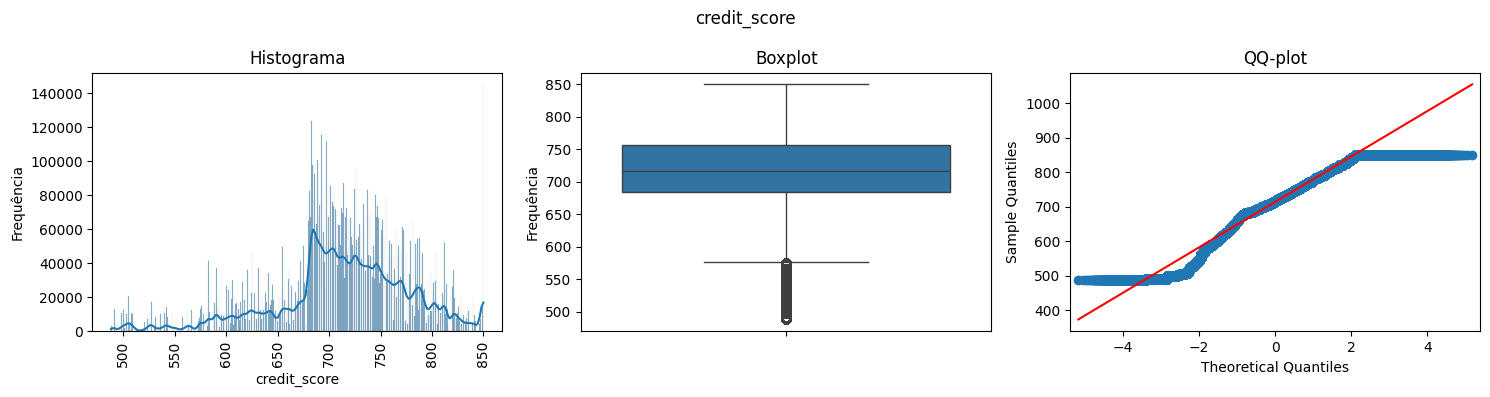

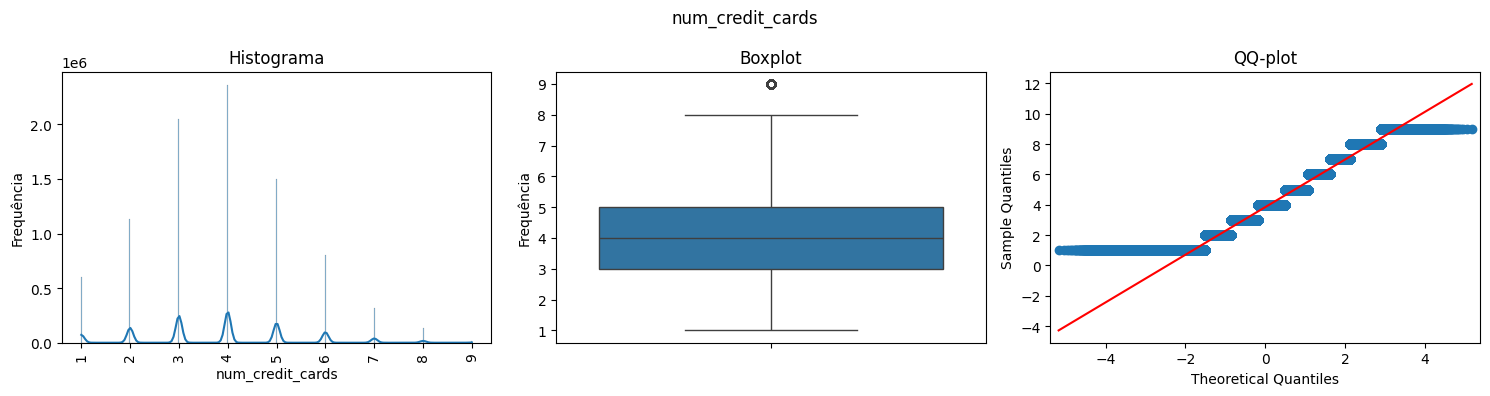

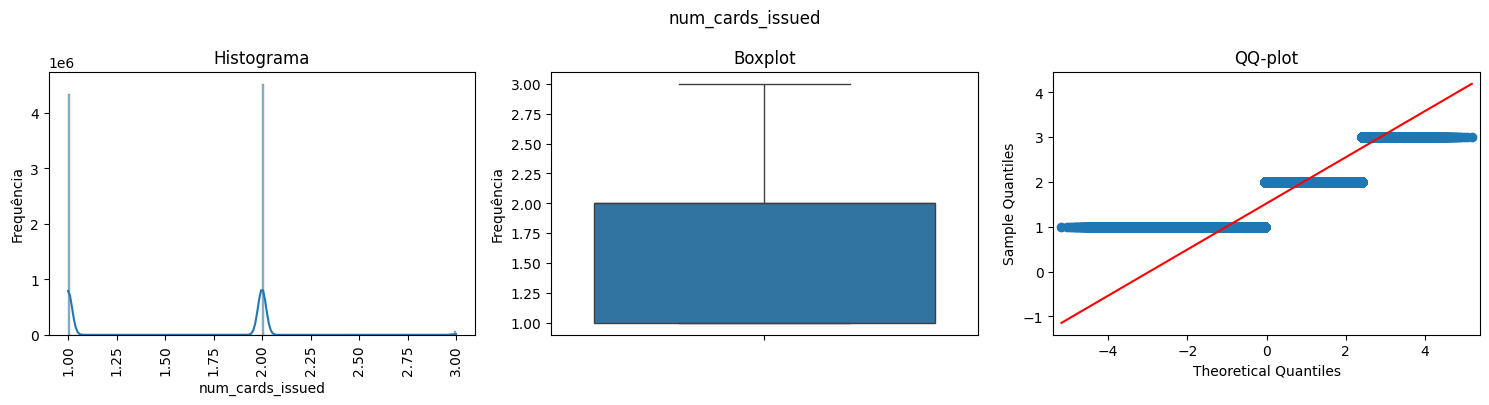

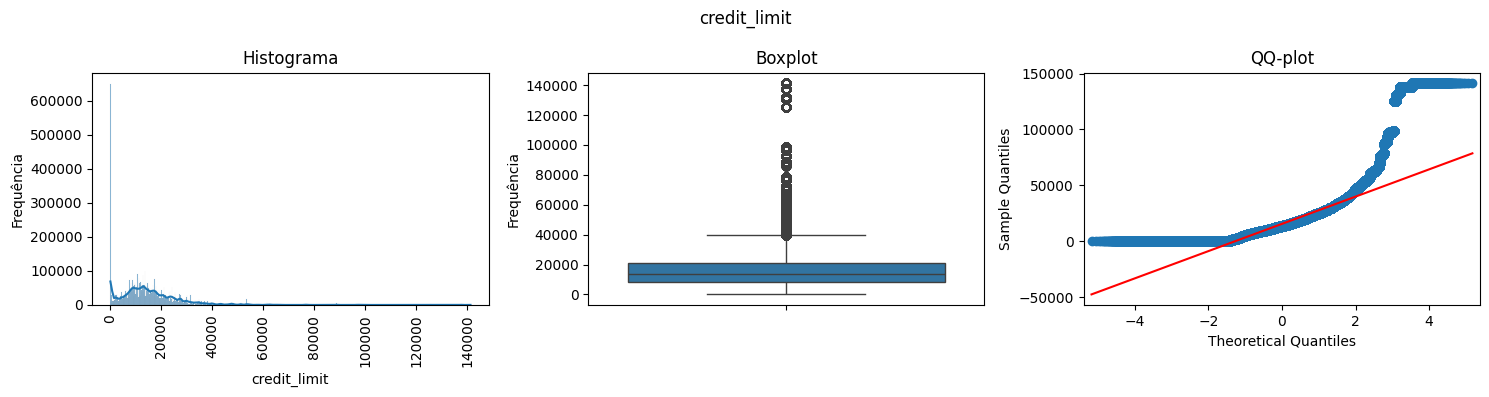

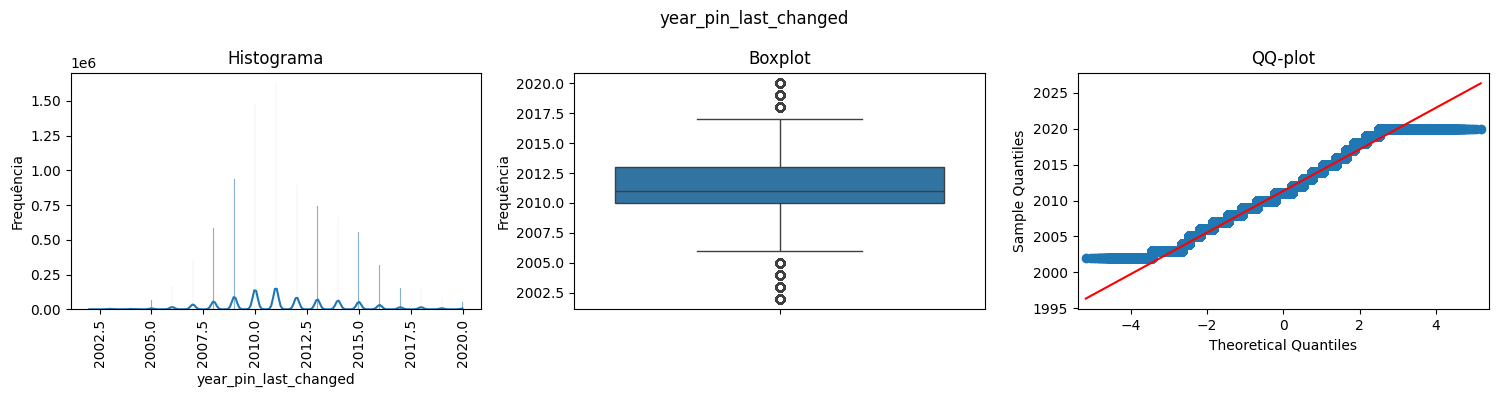

In [26]:
for column in filter(lambda x: x not in ['latitude', 'longitude'], number_columns):
  plot_hist_box(df, column)

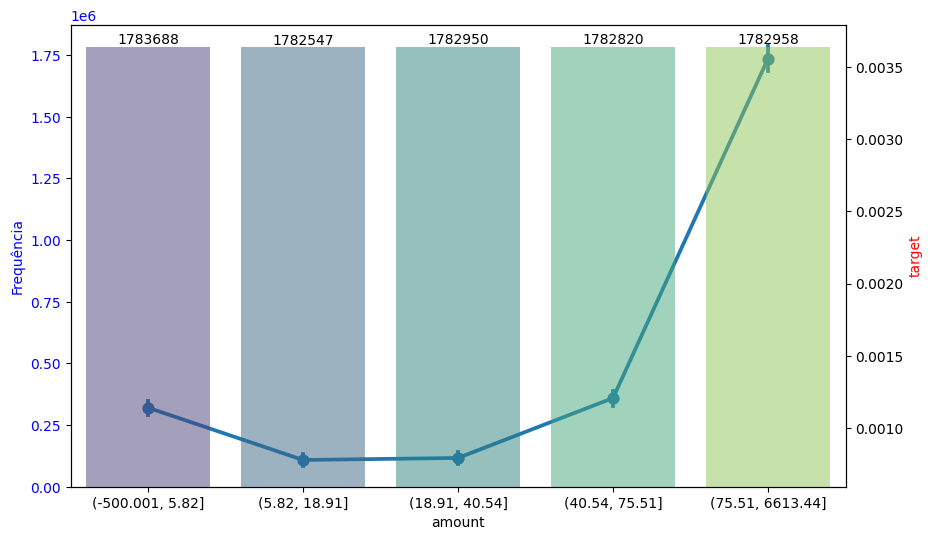

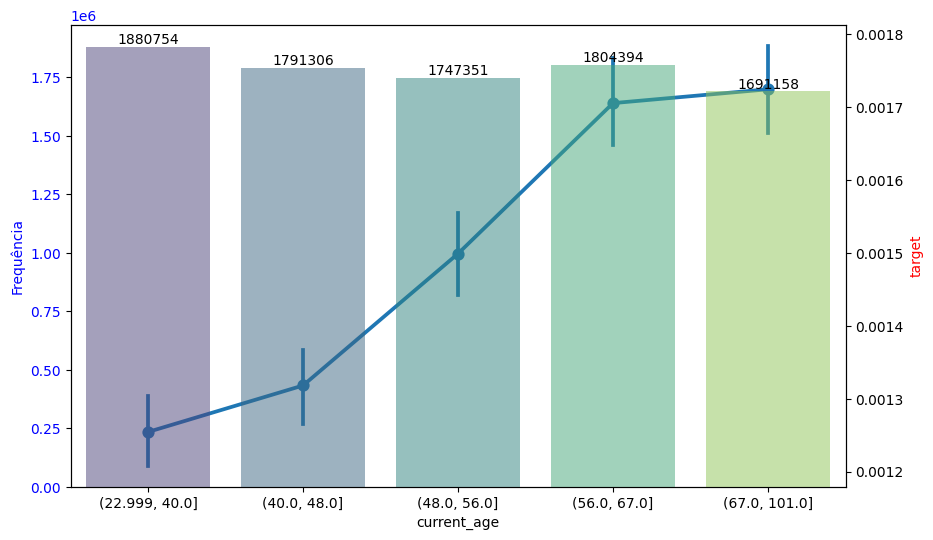

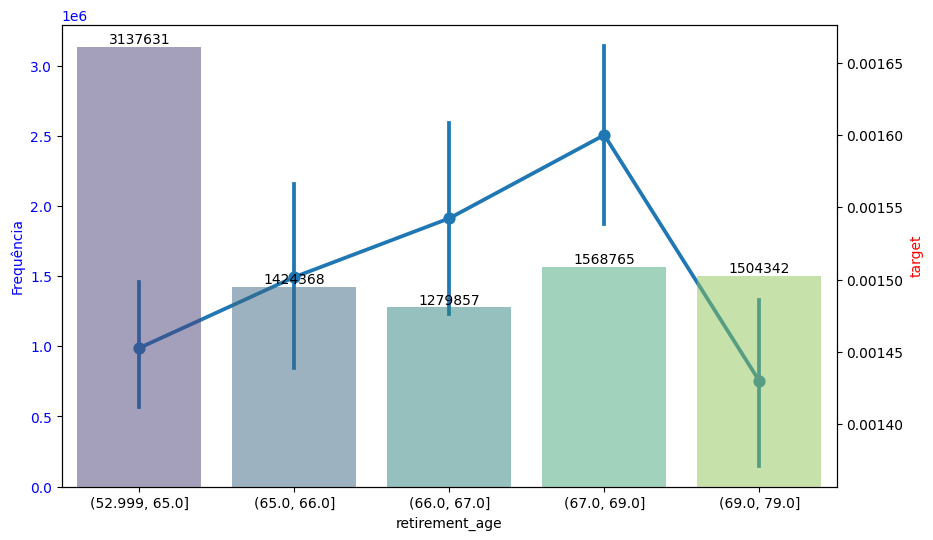

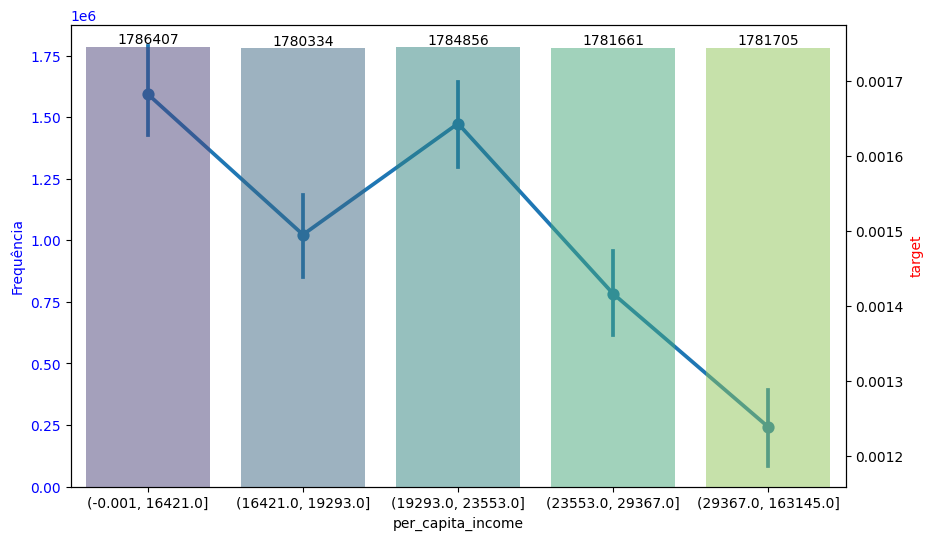

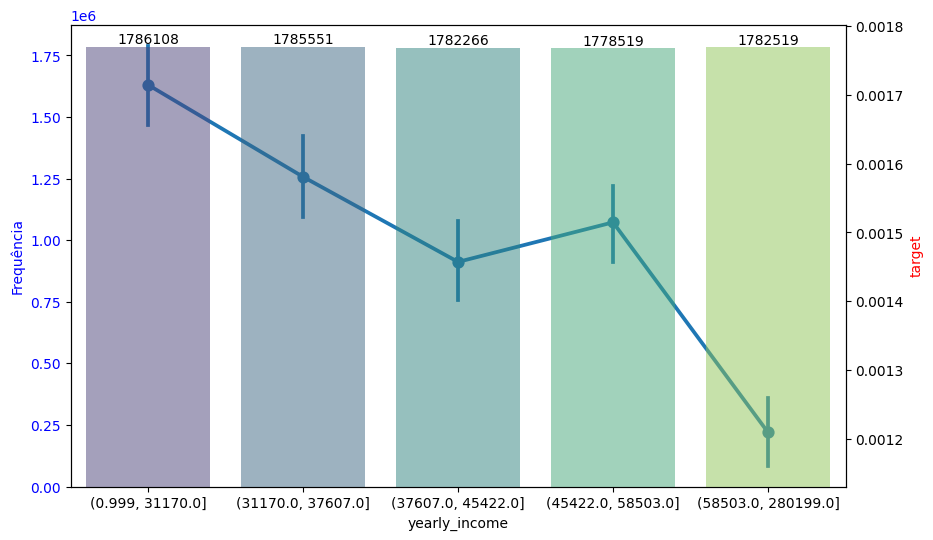

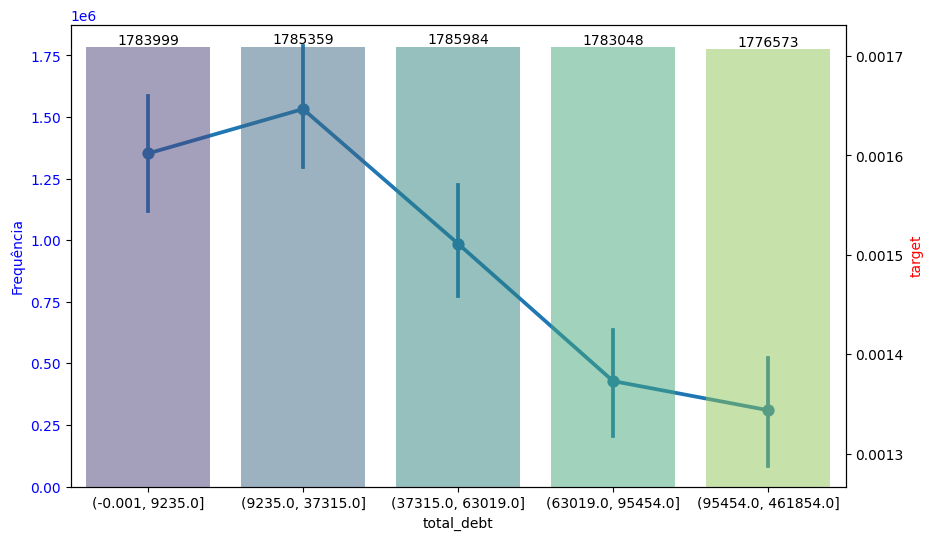

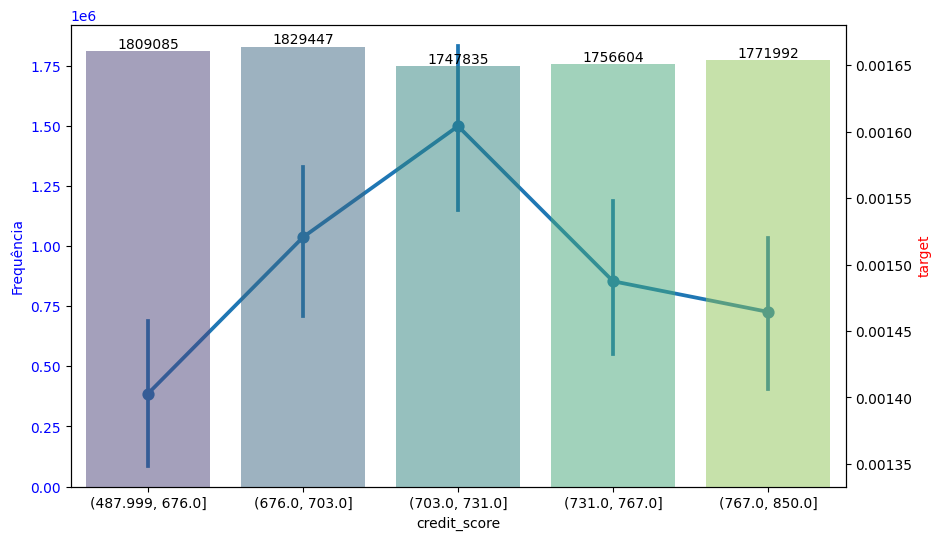

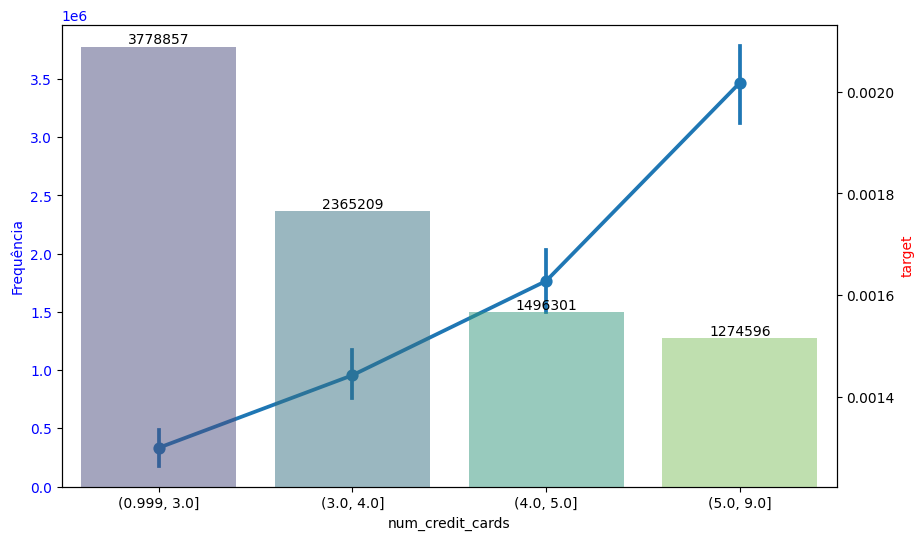

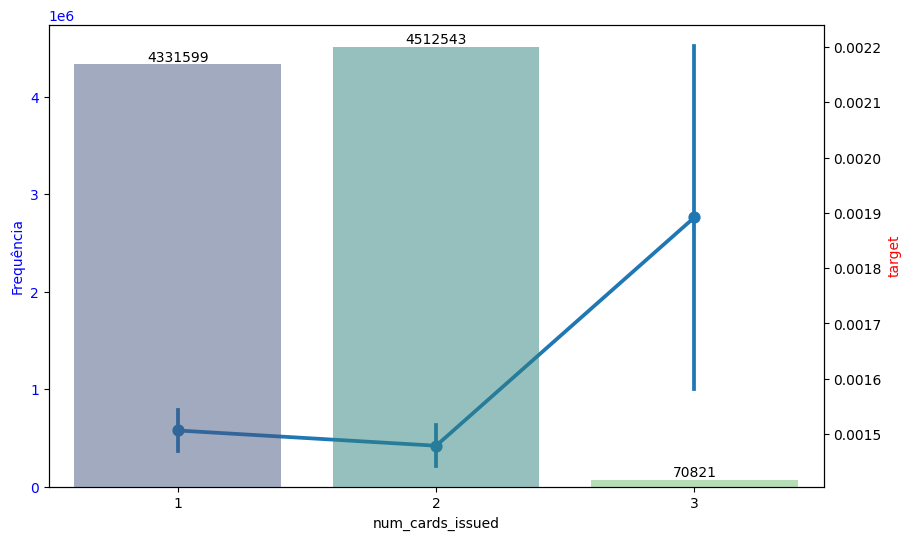

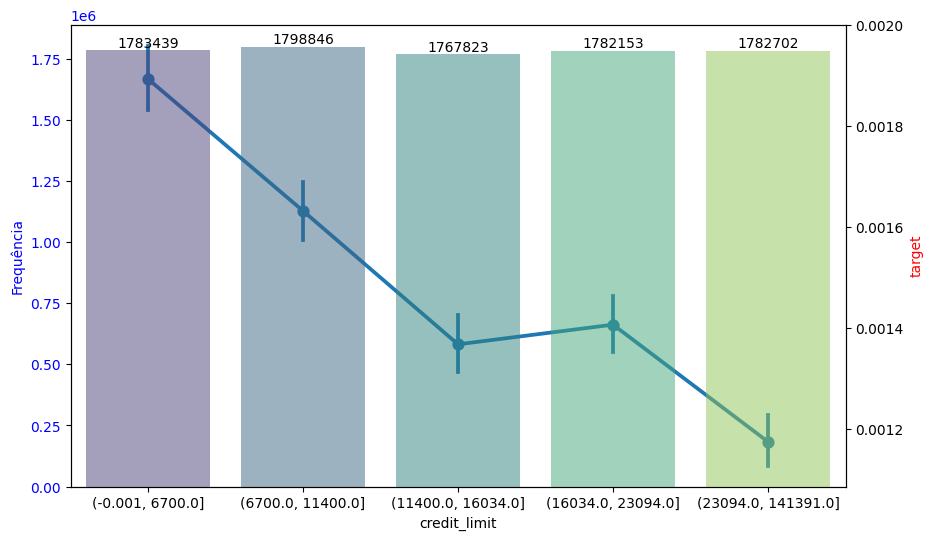

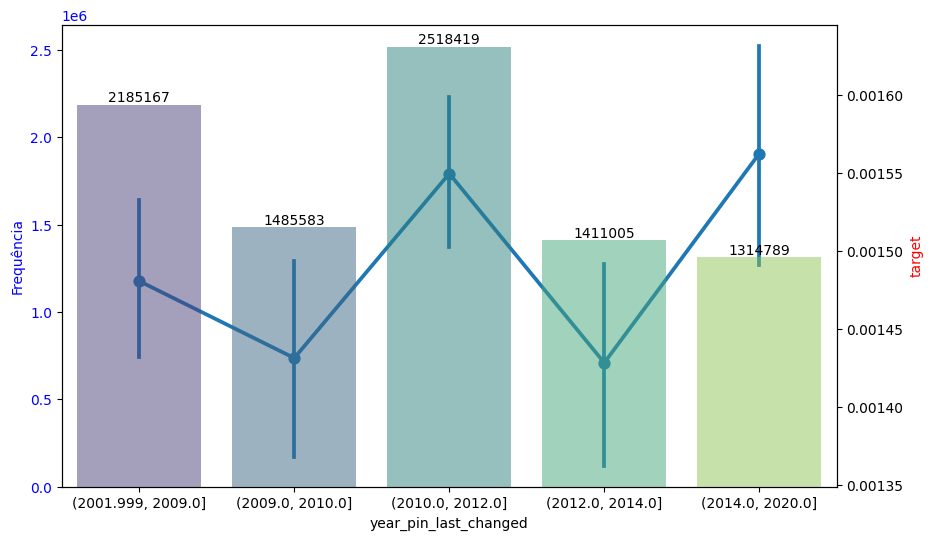

In [27]:
for column in filter(lambda x: x not in ['latitude', 'longitude'], number_columns):
    descritiva(df, column, 'target', map_target={ 'Yes': 1, 'No': 0 })

> amount

* Compras com valor abaixo de 75.71 possui menor indice de fraude

> current_age

* Faixa acima de 67 possui um maior indice de fraude

> retirement_age

* Indice de fraude muito volatil para o as idades de 53 a 79

> per_capita_income

* Indice de fraude maior para as faixas abaixo de 23553

> yearly_income

* Indice de fraude maior para as faixas abaixo de 58503

> total_debit

* Os dados dentro do range do boxplot possui maior indice de fraude

> credit_score

* O credit_score com faixa 703 a 731 possui uma maior taxa de indice de fraude.

> num_credit_cards

* Clientes com quantidade de cartão acima de 4 cartões tem uma taxa muito maior de indice de fraude

> credit_limit

* Clientes com limit de credito menor (abaixo de 6700) apresentam um maior indice de fraude



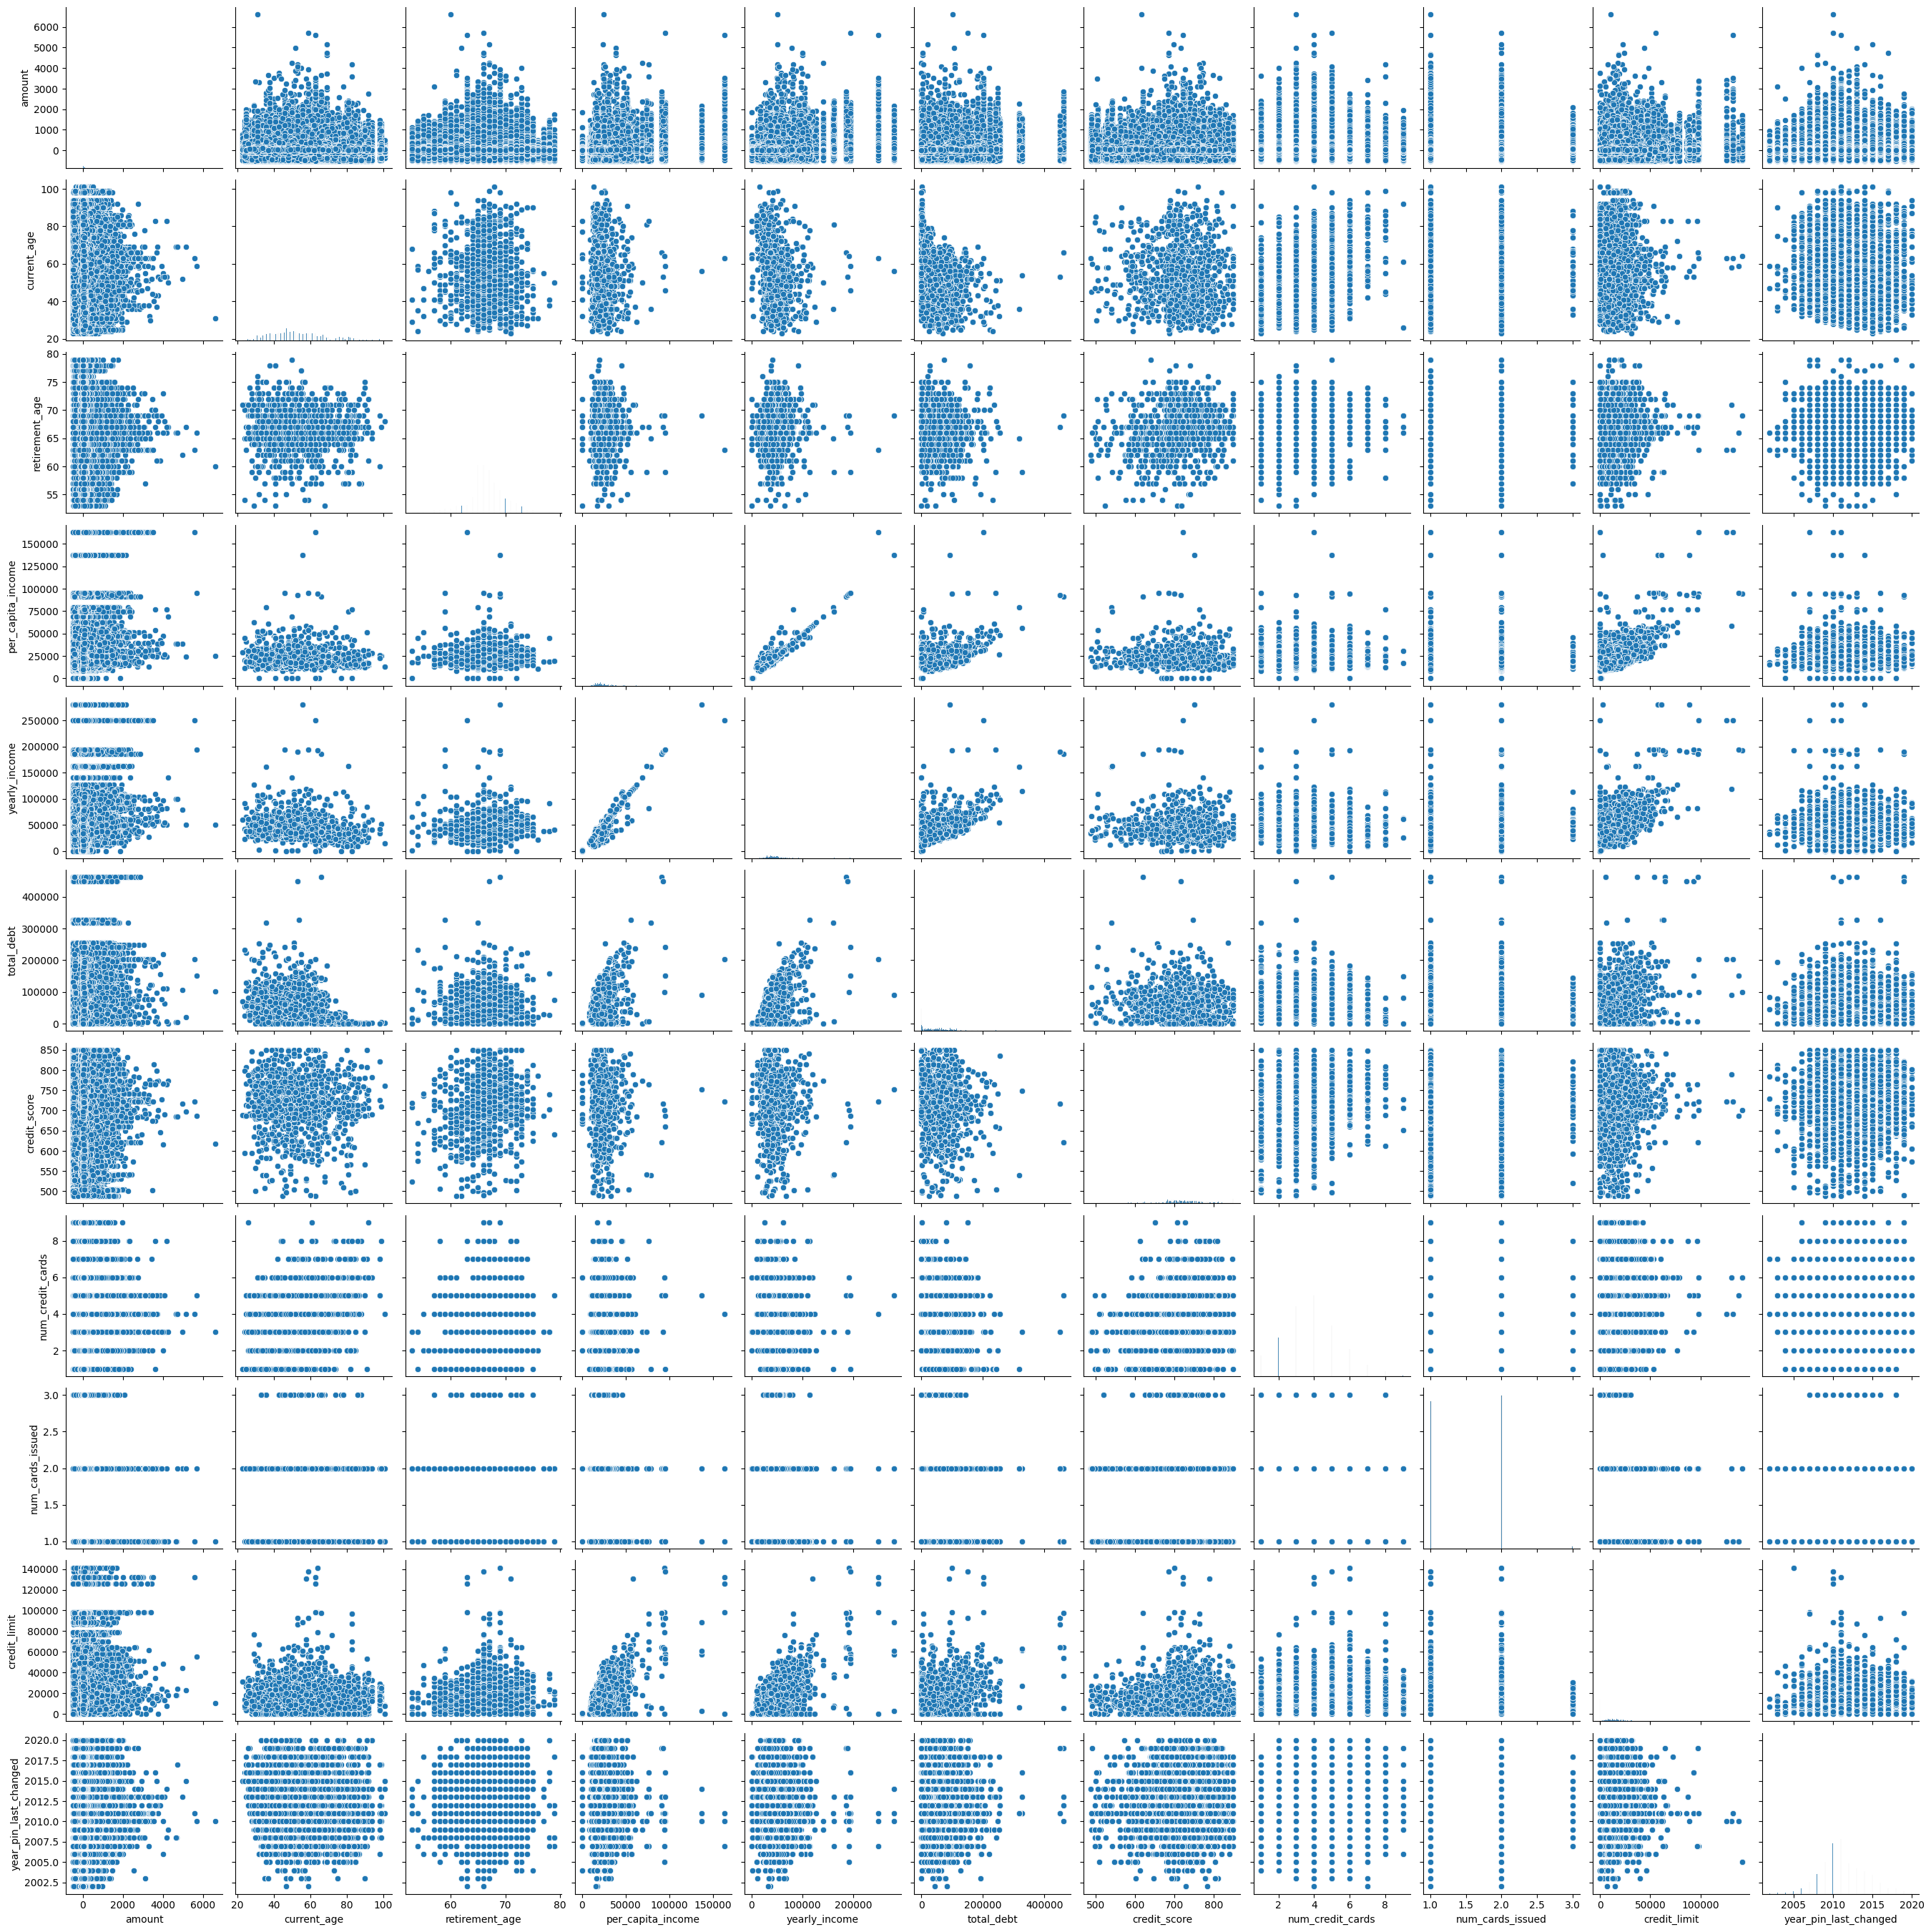

In [28]:
ax = sns.pairplot(df[number_columns].drop(columns=['latitude', 'longitude']))
plt.show()

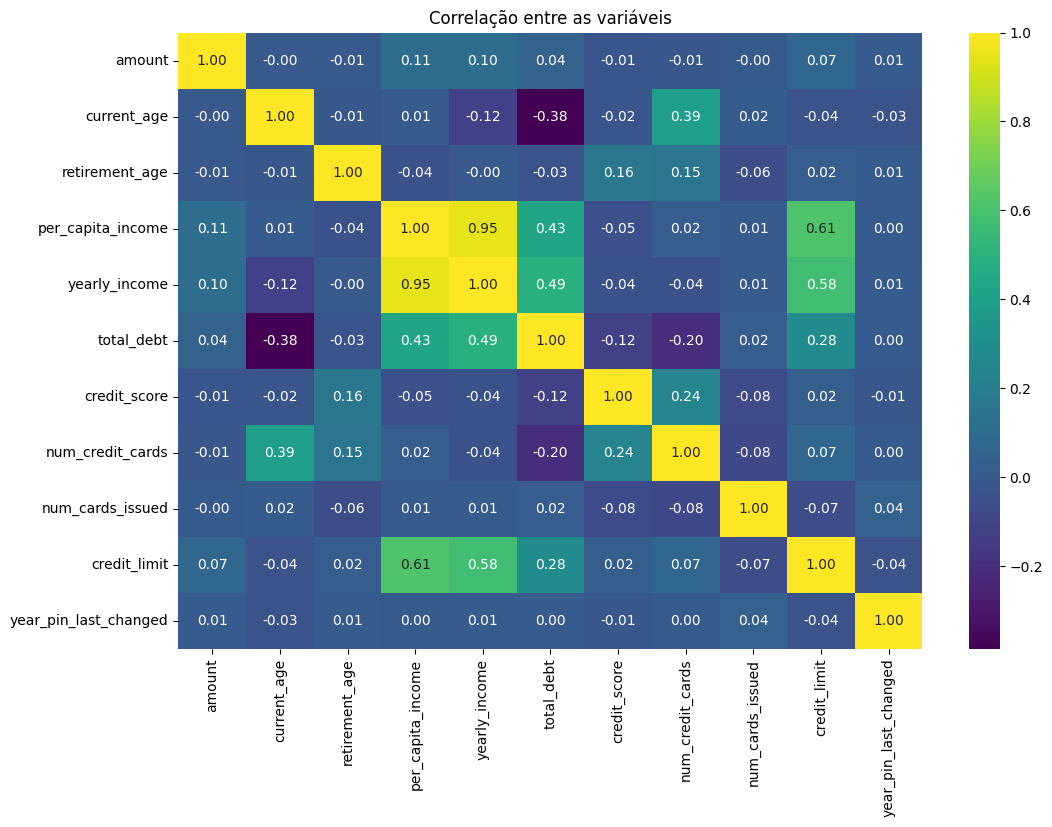

In [29]:
plt.figure(figsize=(12,8))
plt.title('Correlação entre as variáveis')

corr = df[number_columns].drop(columns=['latitude', 'longitude']).corr()
sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

In [30]:
upper_triangle_indices = np.where(np.abs(np.triu(corr, k=1)) > 0.2)
colunas_indices = np.unique(np.concatenate(upper_triangle_indices))
colunas_filtradas = corr.columns[colunas_indices].tolist()
colunas_filtradas


['current_age',
 'per_capita_income',
 'yearly_income',
 'total_debt',
 'credit_score',
 'num_credit_cards',
 'credit_limit']

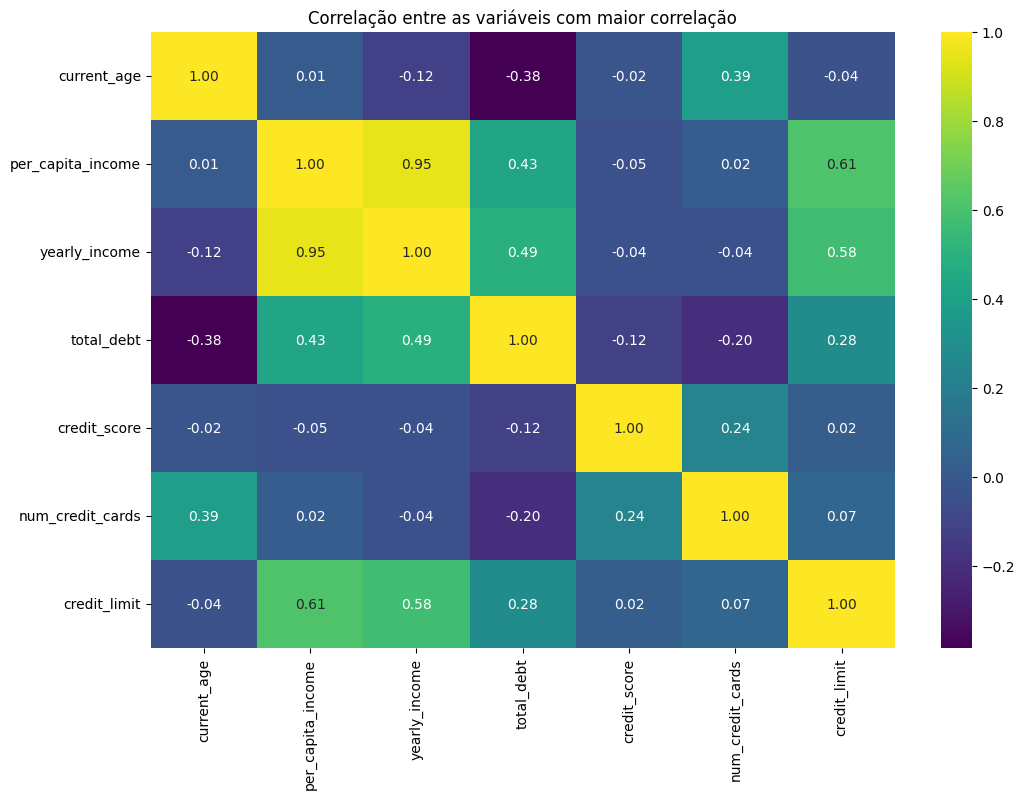

In [31]:
plt.figure(figsize=(12,8))
plt.title('Correlação entre as variáveis com maior correlação')

corr = df[colunas_filtradas].corr()
sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

* Correlação muito alta entre `per_capita_income` e `yearly_income` (0.95) indicando **multicolinearidade**.
* Correlação alta entre `credit_limit` e `per_capita_income` (0.61).
* Correlação alta entre `credit_limit` e `yearly_income` (0.58)

In [32]:
import plotly.express as px

df_fraude = df[df['target'] == 'Yes']

fig = px.scatter_mapbox(df_fraude,
                        lat="latitude",
                        lon="longitude",
                        hover_name="address",  # Informação ao passar o mouse
                        zoom=1,  # Zoom mínimo para mostrar o mundo
                        height=600)          # Altura do mapa

# Define o estilo do mapa (opcional)
fig.update_layout(mapbox_style="open-street-map")

# Ajustando as configurações geográficas para mostrar o mapa completo
fig.update_layout(
    title='Fraude com base na localização do cliente',
    geo=dict(
        scope='world',
        showland=True,
        landcolor="lightgray",
        showocean=True,
        oceancolor="lightblue",
        projection_type='natural earth'
    )
)

fig.show()
fig.write_html('fraude_map.html')
del df_fraude

## Análise Categorica

In [33]:
categorical_columns = df.drop(columns=['id', 'client_id', 'merchant_id', 'card_id']).select_dtypes(include=['object']).columns.tolist()
categorical_columns

['use_chip',
 'merchant_city',
 'merchant_state',
 'zip',
 'mcc',
 'errors',
 'description',
 'target',
 'birth_year',
 'birth_month',
 'gender',
 'address',
 'card_brand',
 'card_type',
 'card_number',
 'expires',
 'cvv',
 'has_chip',
 'acct_open_date',
 'card_on_dark_web']

In [34]:
df[categorical_columns].describe().T

count unique                           top     freq
use_chip          8914963      3             Swipe Transaction  4668212
merchant_city     8914963  12173                        ONLINE  1047865
merchant_state    7867098    199                            CA   956356
zip               8914963  24587                           nan  1107377
mcc               8914963    109                          5411  1066833
errors             141767     22          Insufficient Balance    87686
description       8914963    108  Grocery Stores, Supermarkets  1066833
target            8914963      2                            No  8901631
birth_year        8914963     74                          1972   351081
birth_month       8914963     12                            11   914471
gender            8914963      2                        Female  4567172
address           8914963   1219           772 Fifth Boulevard    32478
card_brand        8914963      4                    Mastercard  4795682
card_type         8914963      3                         Debit  5548196
card_number       8914963   4070               357731604070533    21307
expires           8914963    180                       02/2020   315683
cvv               8914963    983                           265    40398
has_chip          8914963      2                           YES  8022614
acct_open_date    8914963    294                       02/2010   165220
card_on_dark_web  8914963      1                            No  8914963

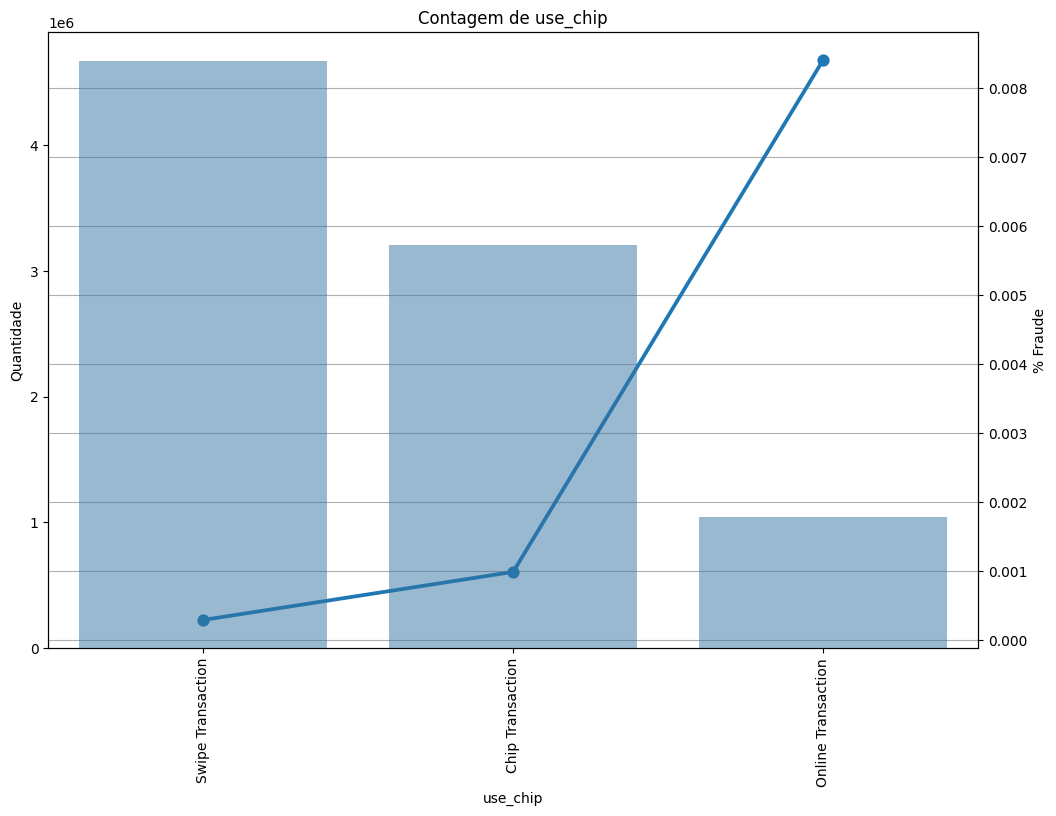

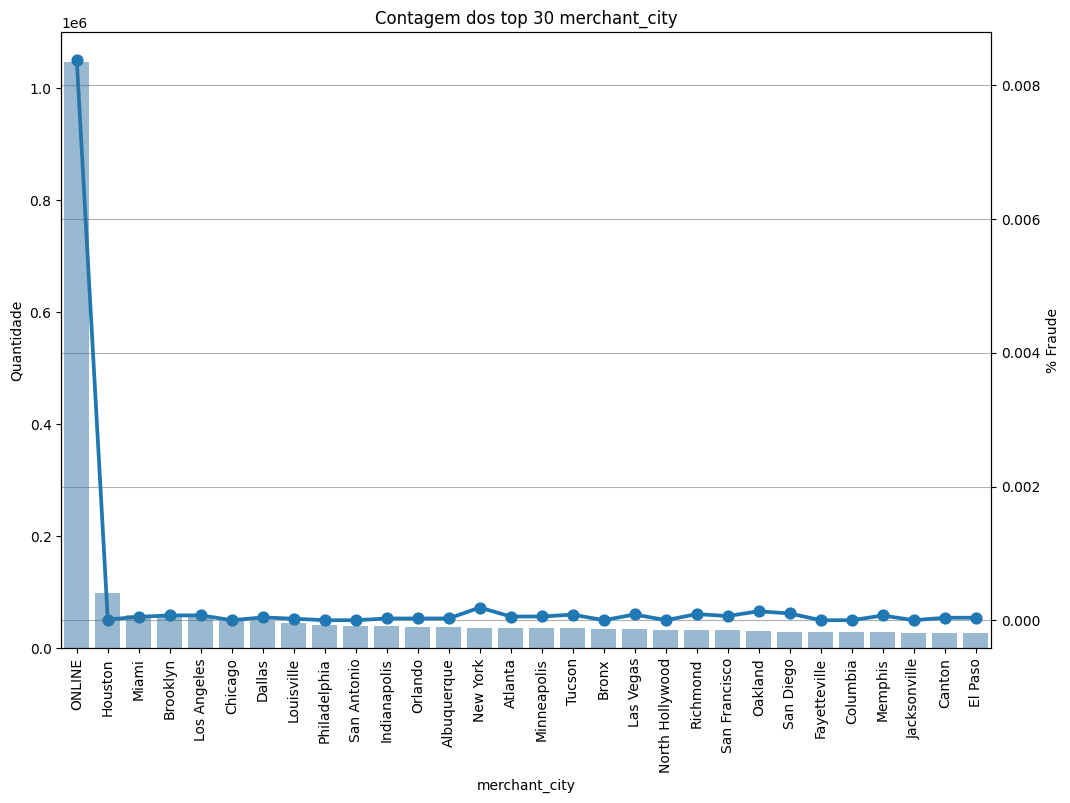

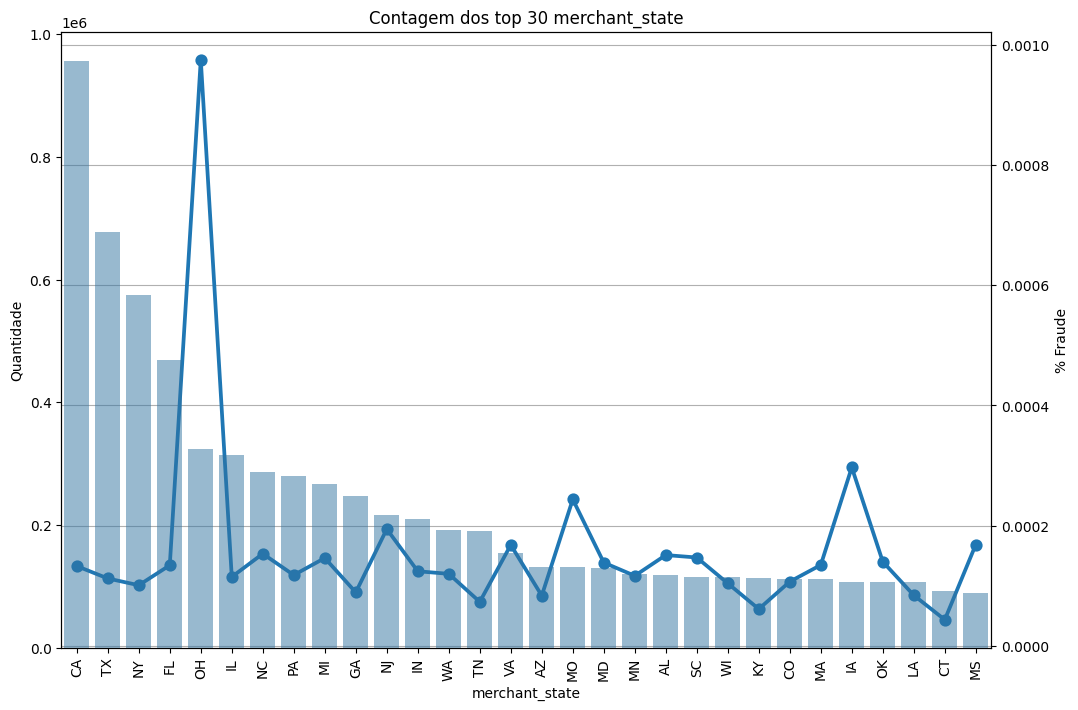

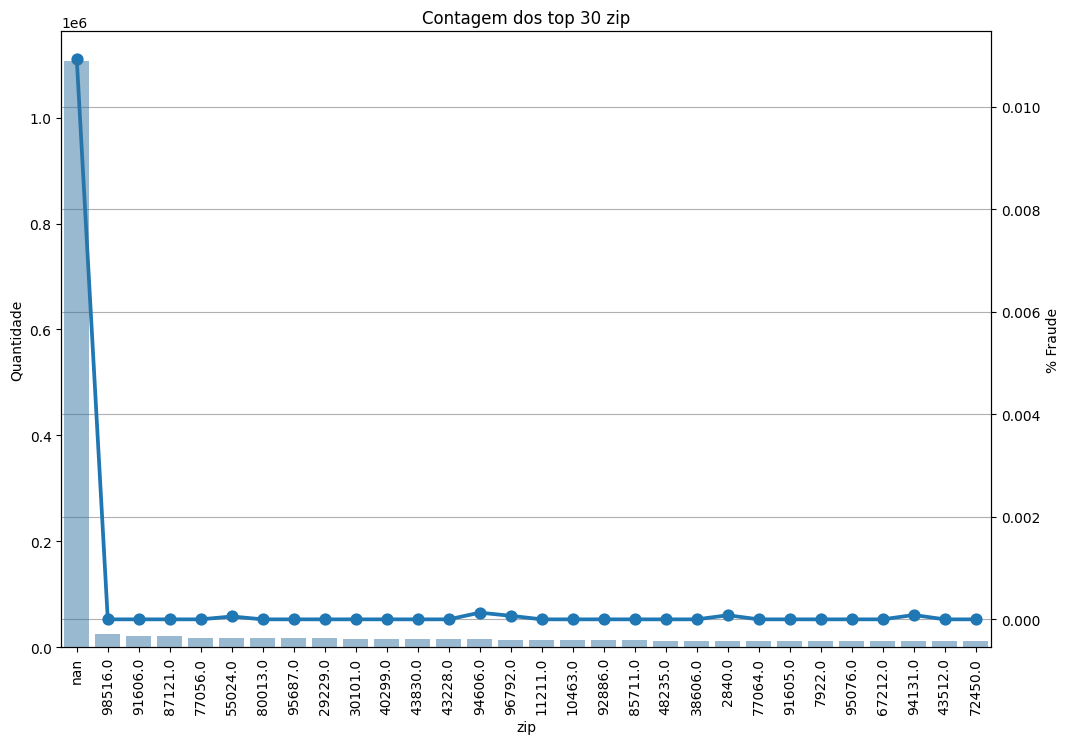

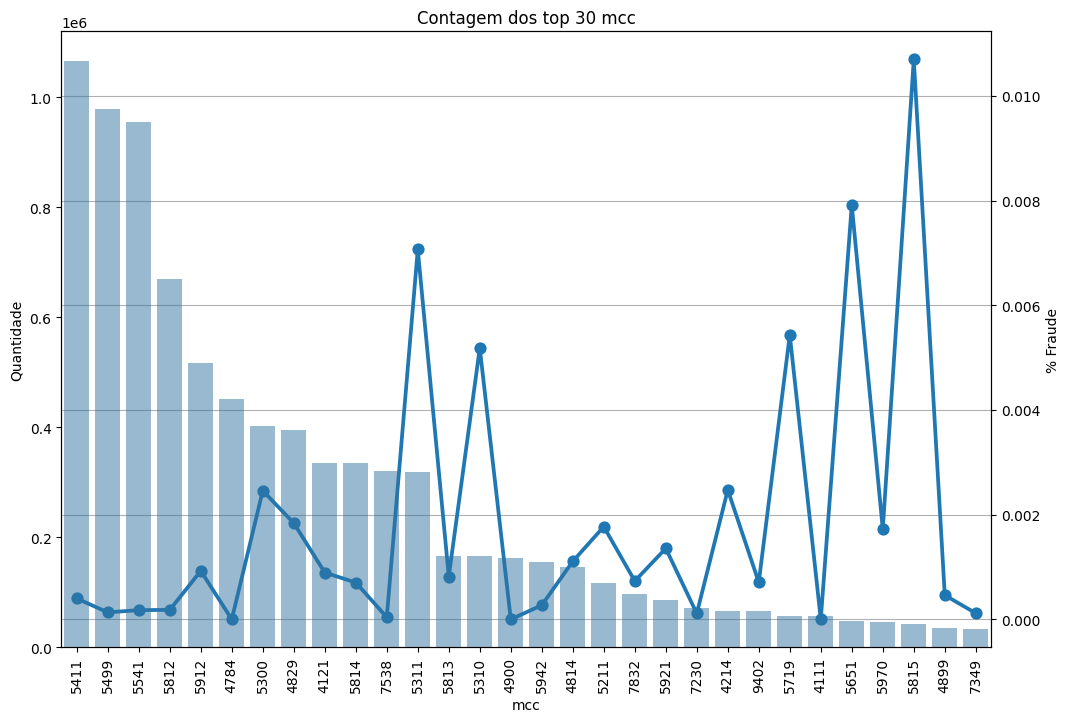

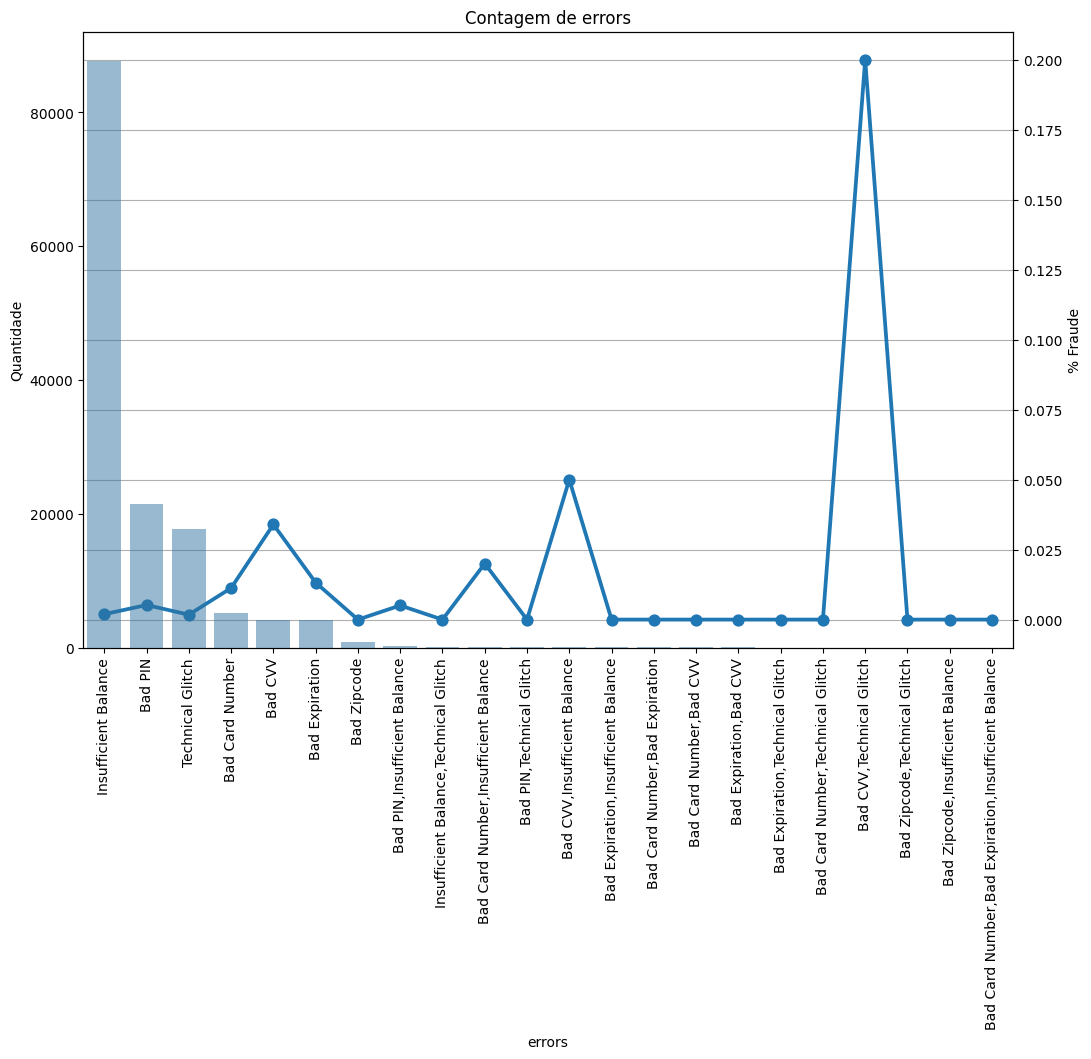

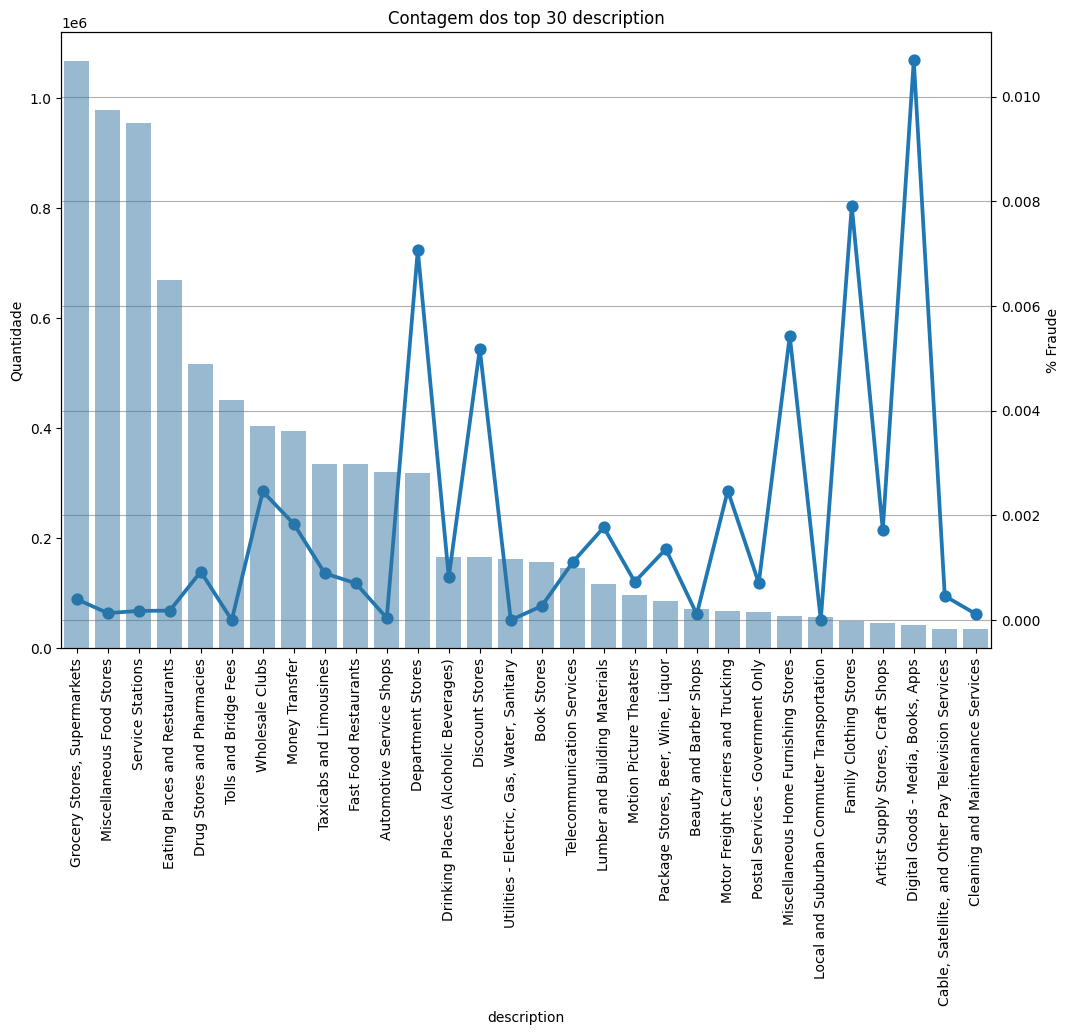

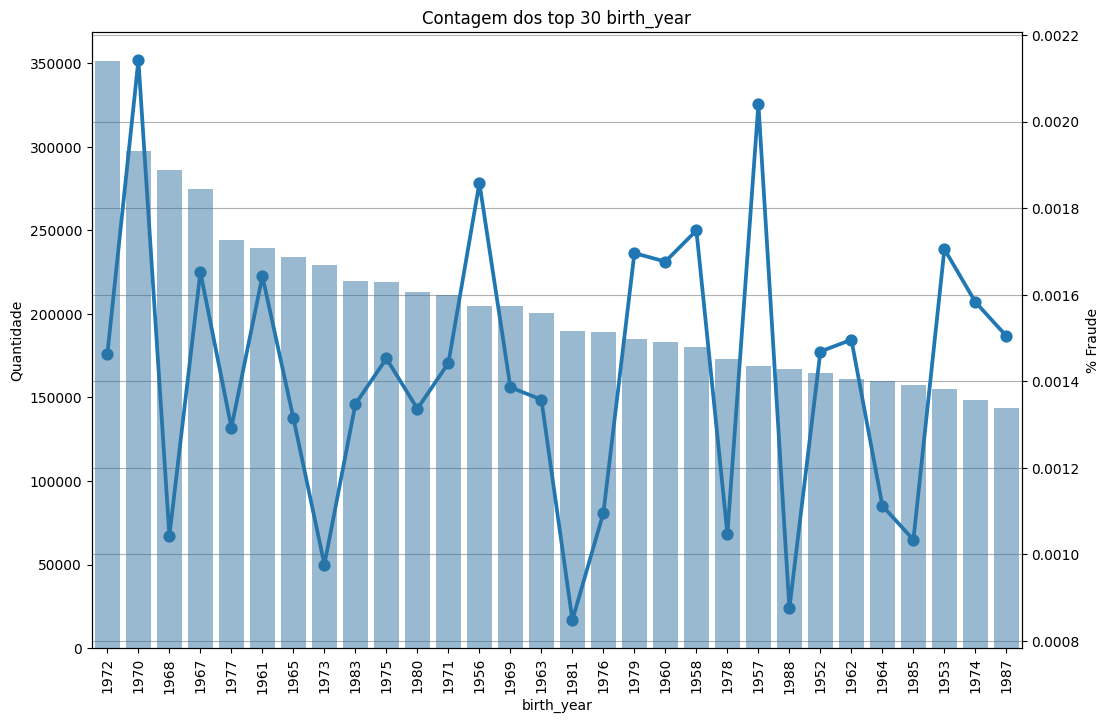

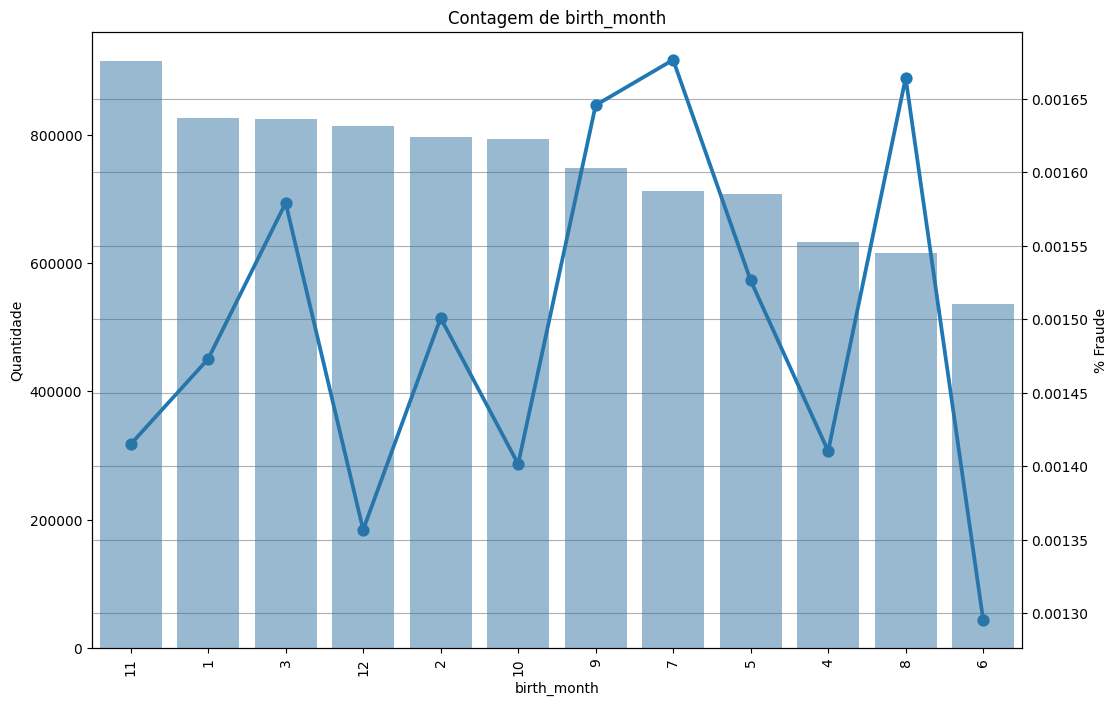

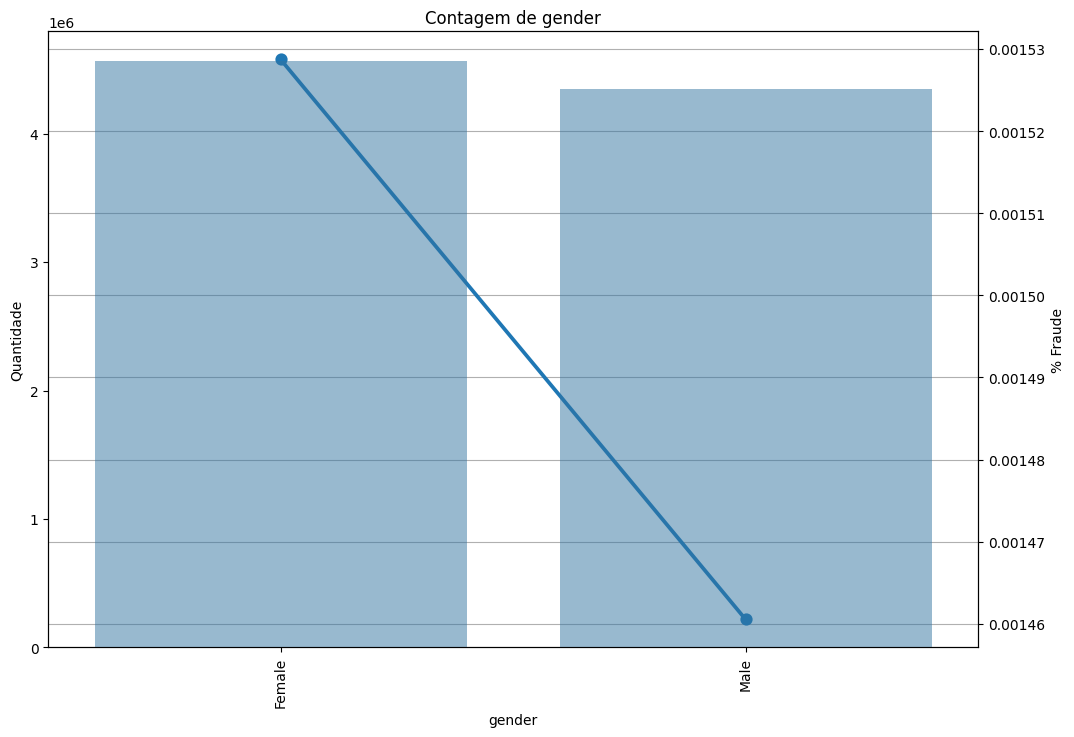

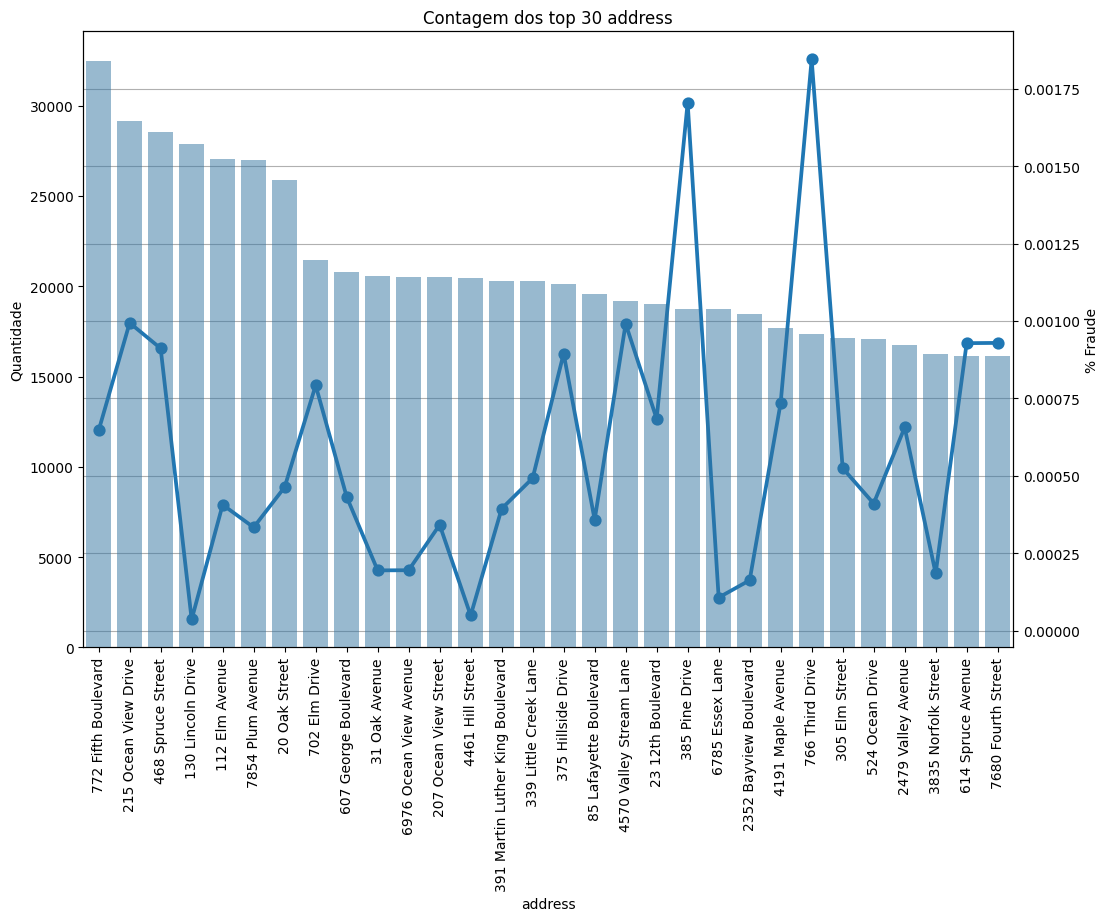

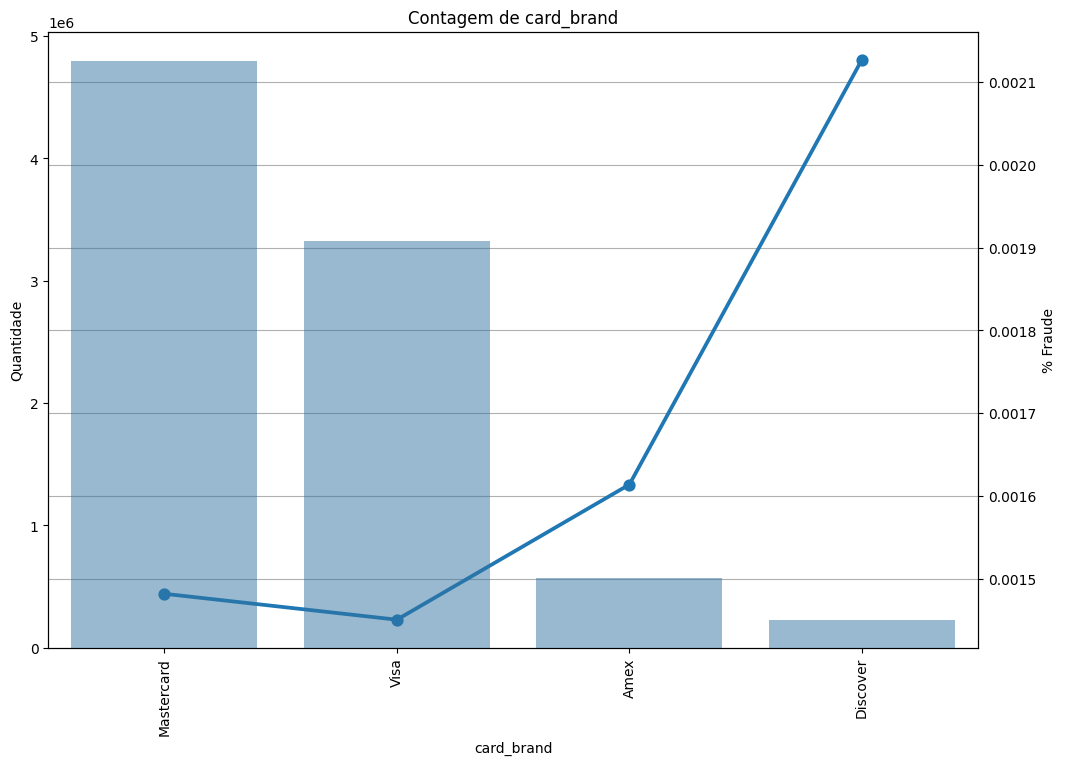

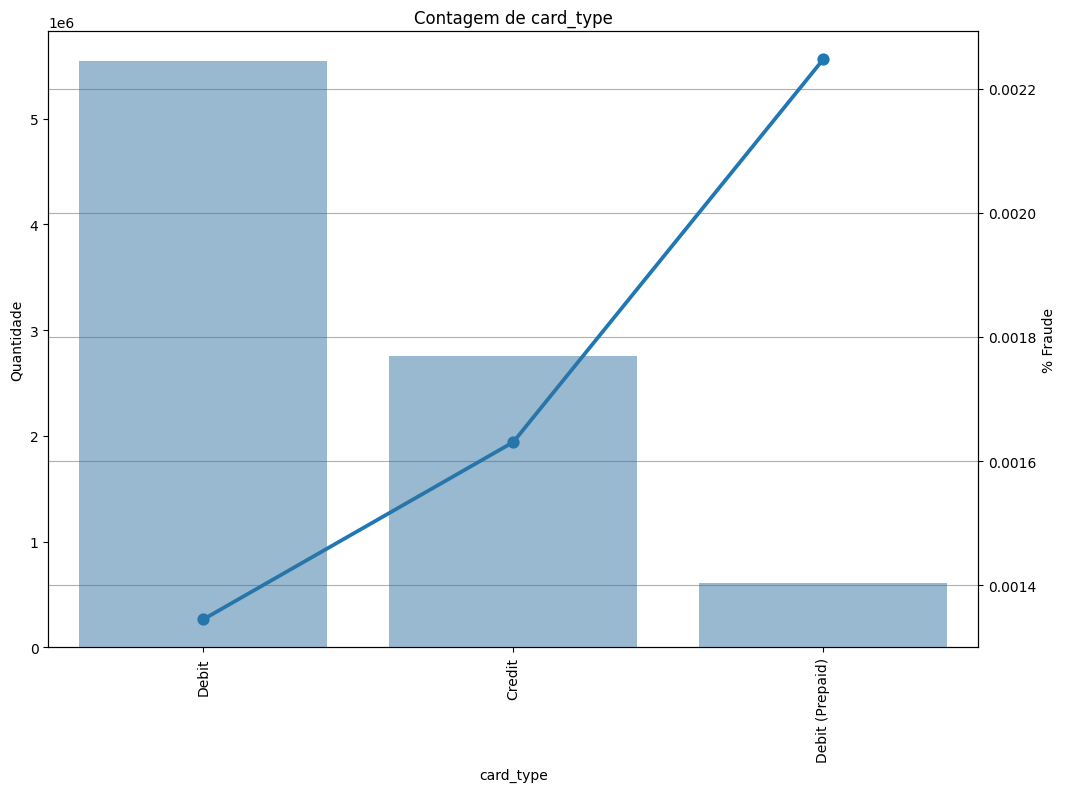

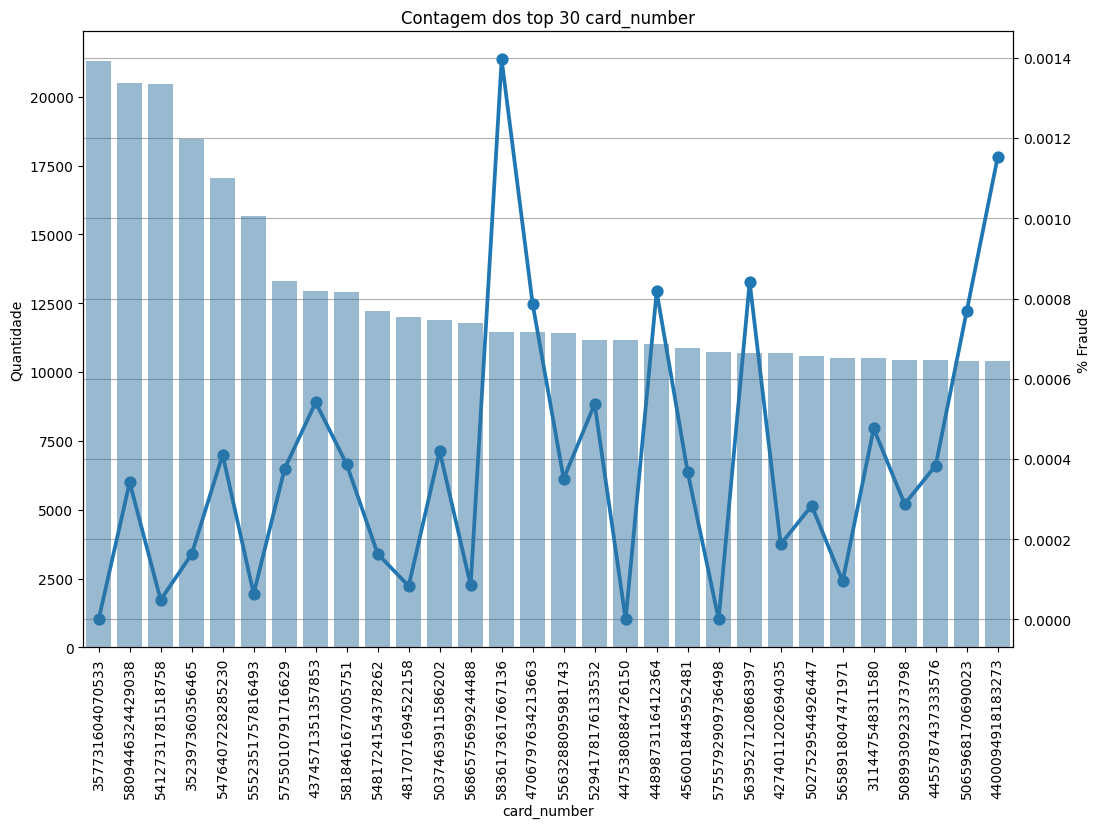

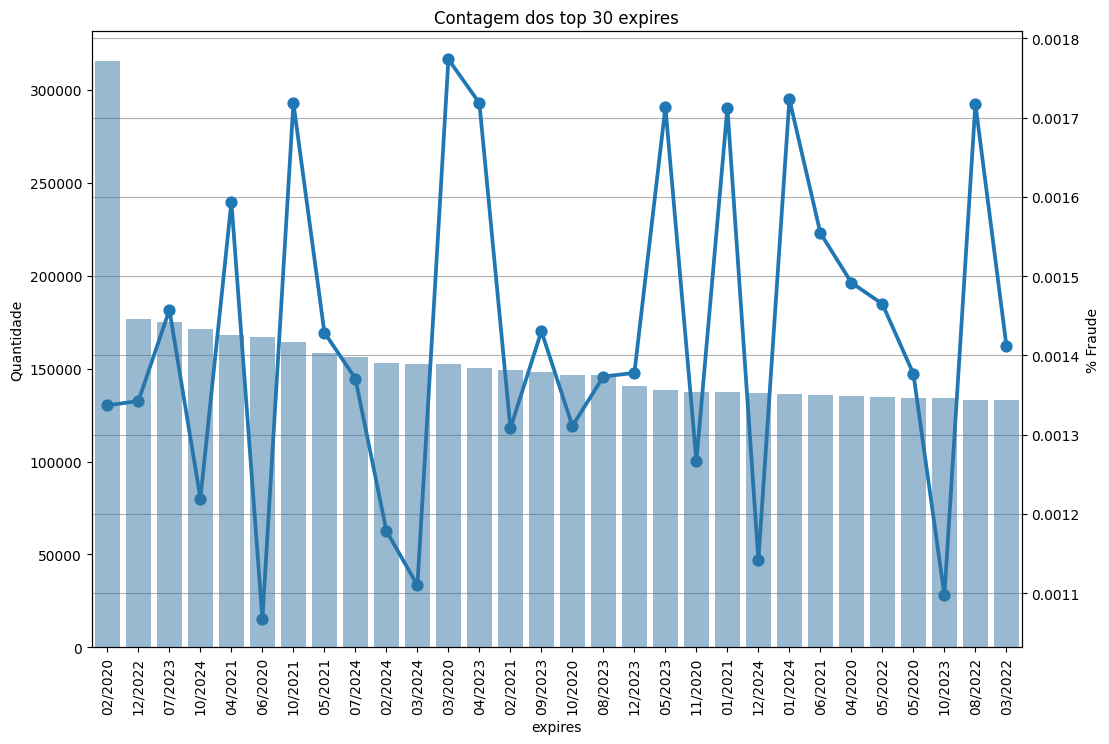

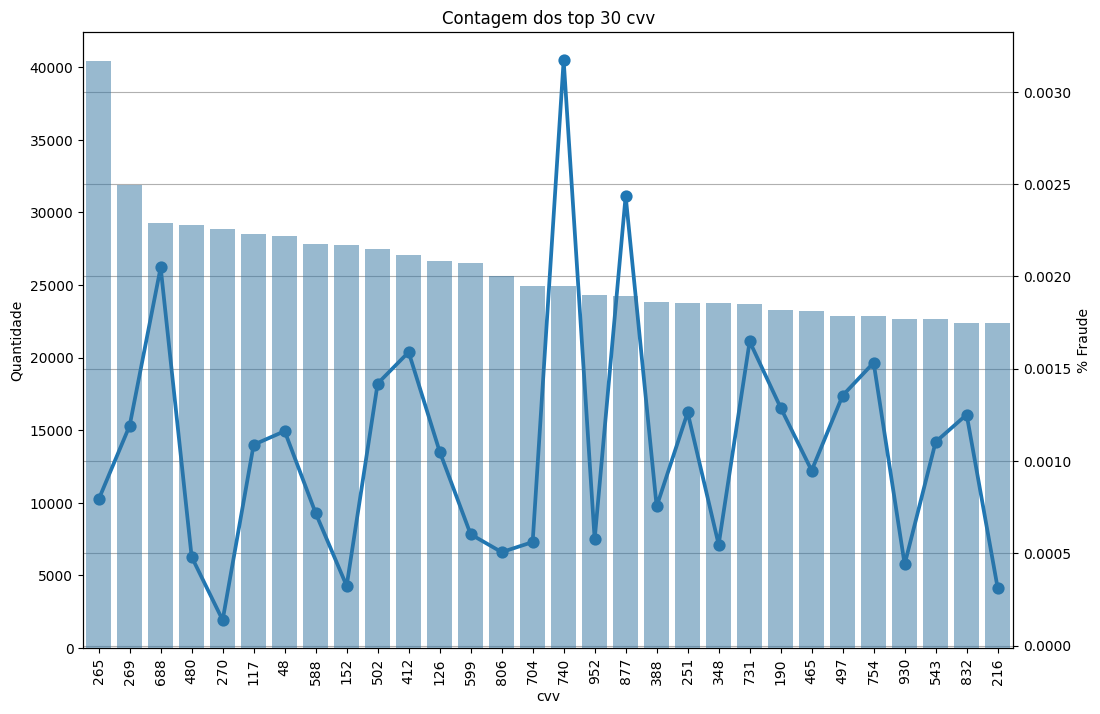

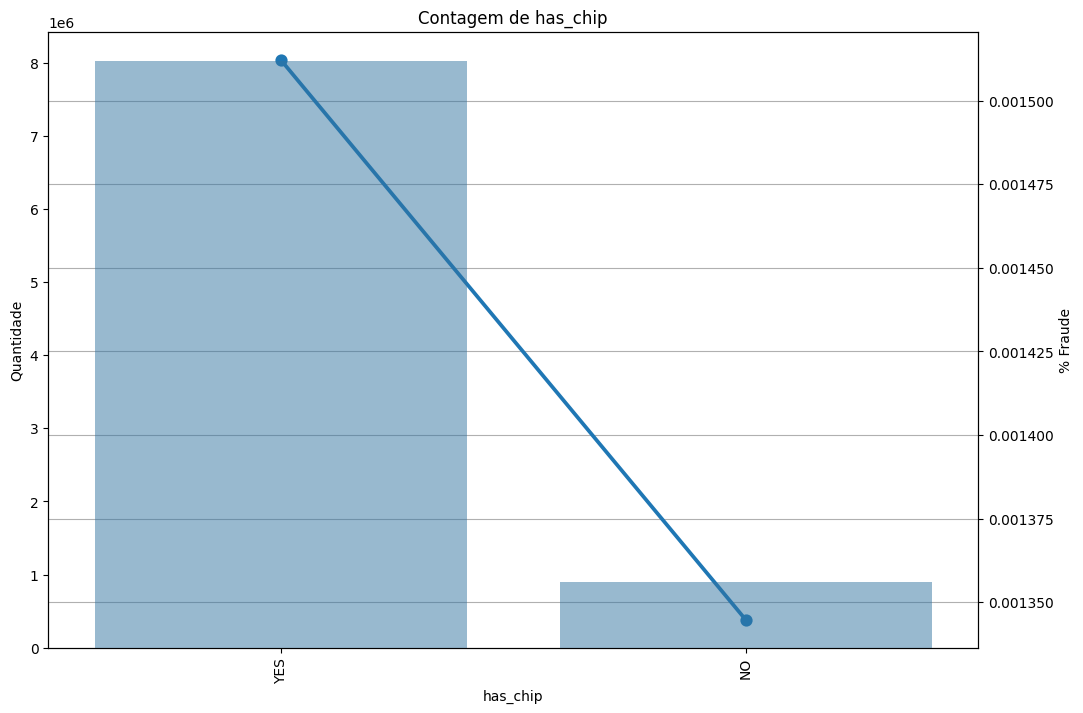

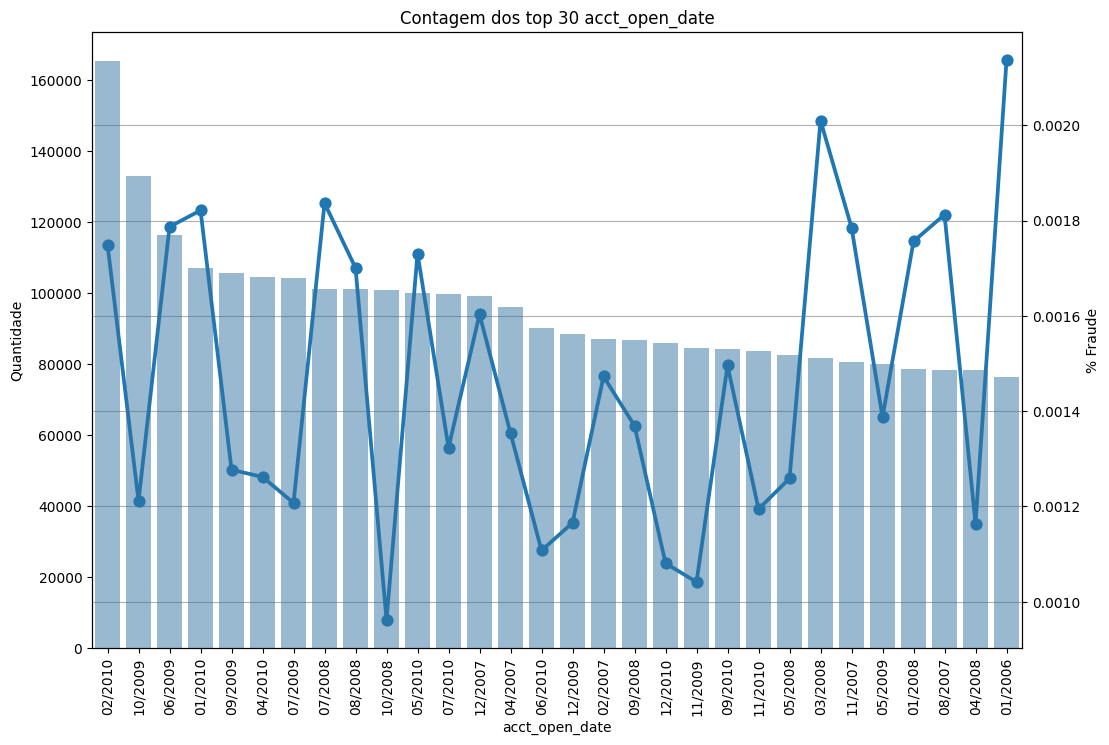

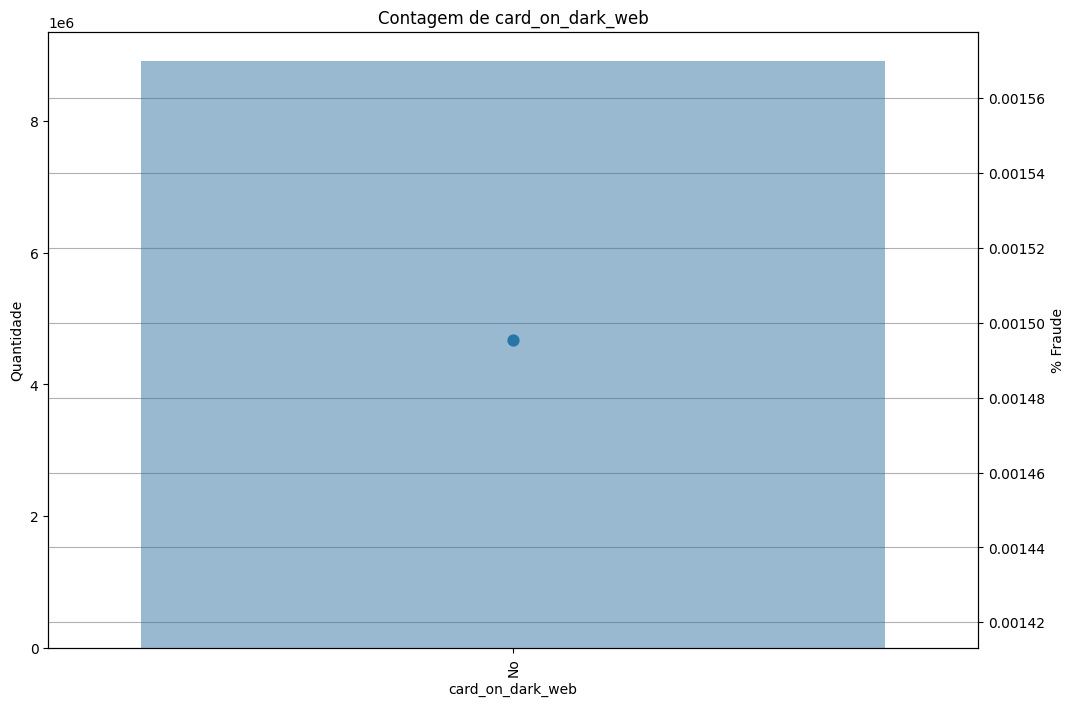

In [35]:
top = 30
for column in categorical_columns:
  if column == 'target':
    continue

  plt.figure(figsize=(12,8))

  df_target = df.groupby(by=[column])['target'].value_counts(normalize=True).reset_index().query('target == "Yes"').drop(columns=['target'])
  df_target.columns = [column, 'percent']
  df_target = pd.merge(df[column].value_counts().reset_index(), df_target, on=column, how='left').fillna(0)

  title = f'Contagem de {column}'
  if len(df_target) > top:
    title = f'Contagem dos top {top} {column}'
    df_target = df_target.iloc[0:top]

  plt.title(title)
  ax = sns.barplot(data=df_target, x=column, y='count', alpha=0.5)
  ax.set_ylabel('Quantidade')
  ax.set_xlabel(column)
  ax.tick_params(axis='x', rotation=90)

  # for container in ax.containers:
  #   ax.bar_label(container, fmt='%d', label_type='edge', padding=5)

  ax2 = ax.twinx()
  ax2 = sns.pointplot(data=df_target, x=column, y='percent', ax=ax2)
  ax2.set_ylabel('% Fraude')

  ax.set_zorder(2)
  ax.patch.set_visible(False)

  plt.grid(True)
  plt.show()
  del df_target

In [36]:
df['merchant_state'].unique()

array(['ND', 'IA', 'CA', 'MD', 'NY', None, 'TX', 'HI', 'PA', 'GA', 'AL',
       'CT', 'WA', 'CO', 'NJ', 'FL', 'MT', 'AZ', 'KY', 'LA', 'OH', 'MI',
       'KS', 'MA', 'WI', 'NC', 'MO', 'AR', 'IL', 'IN', 'SC', 'TN', 'MN',
       'NV', 'OK', 'OR', 'NM', 'SD', 'WV', 'ME', 'VA', 'MS', 'DE', 'NH',
       'VT', 'Mexico', 'ID', 'NE', 'DC', 'UT', 'Vatican City', 'WY', 'RI',
       'Dominican Republic', 'Canada', 'AK', 'Costa Rica', 'Germany',
       'China', 'United Kingdom', 'Tuvalu', 'Taiwan',
       'United Arab Emirates', 'Netherlands', 'Lithuania', 'Japan',
       'Greece', 'Vietnam', 'Haiti', 'Ireland', 'Singapore', 'France',
       'South Africa', 'Thailand', 'Italy', 'Denmark', 'Jamaica', 'Benin',
       'Belgium', 'Sierra Leone', 'Indonesia', 'Colombia', 'Switzerland',
       'Portugal', 'New Zealand', 'Jordan', 'Guatemala', 'Hong Kong',
       'Finland', 'Mongolia', 'Saudi Arabia', 'Norway', 'Philippines',
       'Hungary', 'South Korea', 'Israel', 'India', 'Australia', 'Monaco',
     

In [37]:
df_cat = pd.DataFrame()
df_cat['use_chip'] = df['use_chip']
df_cat['online_sales'] = df['merchant_city'].apply(lambda x: 'Yes' if str(x).lower() == 'online' else 'No')
df_cat['city'] = df['merchant_city'].apply(lambda x: 'Online' if str(x).lower() == 'online' else x)
df_cat['country'] = df['merchant_state'].apply(lambda x: 'United States' if x and len(x) == 2 else x)
df_cat['category'] = df['description']
df_cat['gender'] = df['gender']
df_cat['card_brand'] = df['card_brand']
df_cat['card_type'] = df['card_type']
df_cat['card_expires'] = df['expires']
df_cat['card_has_chip'] = df['has_chip'].apply(lambda x: 'Yes' if x == 'YES' else 'No')
df_cat['card_payment'] = df_cat['use_chip']
df_cat['target'] = df['target']
df_cat.head()

use_chip online_sales        city        country  \
0  Swipe Transaction           No      Beulah  United States   
1  Swipe Transaction           No  Bettendorf  United States   
2  Swipe Transaction           No       Vista  United States   
3  Swipe Transaction           No     Harwood  United States   
4  Swipe Transaction           No       Bronx  United States   

                                category  gender  card_brand        card_type  \
0              Miscellaneous Food Stores  Female  Mastercard  Debit (Prepaid)   
1                      Department Stores    Male  Mastercard           Credit   
2                         Money Transfer    Male  Mastercard            Debit   
3  Drinking Places (Alcoholic Beverages)    Male        Visa            Debit   
4                            Book Stores  Female  Mastercard  Debit (Prepaid)   

  card_expires card_has_chip       card_payment target  
0      07/2022           Yes  Swipe Transaction     No  
1      12/2024           Yes  Swipe Transaction     No  
2      05/2020           Yes  Swipe Transaction     No  
3      01/2020           Yes  Swipe Transaction     No  
4      03/2014           Yes  Swipe Transaction     No

# Fórmulas: Teste Qui-Quadrado e V de Cramer

Fórmulas para o teste Qui-Quadrado de Independência e a Medida de Associação V de Cramer.

## Teste Qui-Quadrado de Independência

O teste Qui-Quadrado ($\chi^2$) é utilizado para determinar se existe uma associação estatisticamente significativa entre duas ou mais variáveis categóricas. A fórmula para a estatística Qui-Quadrado é:

$$\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

Onde:

* $\chi^2$ = Estatística Qui-Quadrado
* $\sum$ = Símbolo de somatório (soma sobre todas as células da tabela)
* $r$ = Número de linhas na tabela de contingência
* $c$ = Número de colunas na tabela de contingência
* $O_{ij}$ = Frequência observada na célula da linha $i$ e coluna $j$
* $E_{ij}$ = Frequência esperada na célula da linha $i$ e coluna $j$, calculada como:

    $$E_{ij} = \frac{(\text{Total da Linha } i) \times (\text{Total da Coluna } j)}{\text{Total Geral de Observações}}$$

Os graus de liberdade (gl) para o teste Qui-Quadrado em uma tabela de contingência $r \times c$ são calculados como:

$$gl = (r - 1) \times (c - 1)$$

O p-valor associado à estatística Qui-Quadrado é então utilizado para determinar a significância estatística da associação. Um p-valor baixo (tipicamente < 0.05) sugere que há evidências suficientes para rejeitar a hipótese nula de independência entre as variáveis.

## V de Cramer

O V de Cramer (às vezes denotado como $\phi_C$) é uma medida de associação entre duas variáveis categóricas nominais. É uma normalização da estatística Qui-Quadrado que fornece um valor entre 0 e 1, indicando a força da associação. A fórmula para o V de Cramer é:

$$V = \sqrt{\frac{\chi^2}{n \times \min(k-1, r-1)}}$$

Onde:

* $V$ = V de Cramer
* $\chi^2$ = Estatística Qui-Quadrado obtida do teste de independência
* $n$ = Número total de observações na tabela de contingência
* $k$ = Número de colunas na tabela de contingência
* $r$ = Número de linhas na tabela de contingência
* $\min(k-1, r-1)$ = O menor valor entre os graus de liberdade da variável de coluna ($k-1$) e os graus de liberdade da variável de linha ($r-1$)

**Interpretação do V de Cramer:**

* Próximo de 0: Associação fraca ou inexistente.
* Próximo de 1: Associação forte.

Não existem limites rígidos para a interpretação, mas algumas diretrizes comuns incluem:

* 0.0 - 0.1: Associação desprezível
* 0.1 - 0.3: Associação fraca
* 0.3 - 0.5: Associação moderada
* \> 0.5: Associação forte

O V de Cramer é útil para comparar a força da associação entre diferentes pares de variáveis, mesmo que as tabelas de contingência tenham dimensões diferentes.

In [38]:
P_VALUE = 0.05
V_VALUE = 0.1
selected_columns = ['target']

for column in df_cat.query('target == "Yes"').columns:
  if column == 'target':
    continue

  cross_table = pd.crosstab(df_cat[column], df_cat['target'])
  test_chi2 = stats.chi2_contingency(cross_table)

  n = np.sum(cross_table.values)
  min_dim = np.min(cross_table.values.shape) - 1

  V = np.sqrt((test_chi2[0] / n) / min_dim) if min_dim > 0 else np.nan

  print(f"{column} x target")
  print(f"estatística qui²: {round(test_chi2[0], 2)}")
  print(f"p-valor da estatística: {round(test_chi2[1], 4)}")
  print(f"graus de liberdade: {test_chi2[2]}")
  print(f"estatística V: {round(V, 2)}")
  print('')

  if test_chi2[1] < P_VALUE and V >= V_VALUE:
    selected_columns.append(column)

print(selected_columns)

use_chip x target
estatística qui²: 38468.72
p-valor da estatística: 0.0
graus de liberdade: 2
estatística V: 0.07

online_sales x target
estatística qui²: 37663.42
p-valor da estatística: 0.0
graus de liberdade: 1
estatística V: 0.06

city x target
estatística qui²: 1450270.6
p-valor da estatística: 0.0
graus de liberdade: 12172
estatística V: 0.4

country x target
estatística qui²: 3865865.93
p-valor da estatística: 0.0
graus de liberdade: 147
estatística V: 0.7

category x target
estatística qui²: 187514.21
p-valor da estatística: 0.0
graus de liberdade: 107
estatística V: 0.15

gender x target
estatística qui²: 6.9
p-valor da estatística: 0.0086
graus de liberdade: 1
estatística V: 0.0

card_brand x target
estatística qui²: 70.42
p-valor da estatística: 0.0
graus de liberdade: 3
estatística V: 0.0

card_type x target
estatística qui²: 349.38
p-valor da estatística: 0.0
graus de liberdade: 2
estatística V: 0.01

card_expires x target
estatística qui²: 1509.06
p-valor da estatística:

In [158]:
mca = prince.MCA(n_components=2)
mca.fit(df_cat.query('target == "Yes"')[selected_columns])

MCA()

In [159]:
coord_padrao = mca.column_coordinates(df_cat.query('target == "Yes"')[selected_columns])/np.sqrt(mca.eigenvalues_)
chart = coord_padrao.reset_index()

In [160]:
chart

index         0         1
0                                target__Yes -0.152437  0.057724
1                              city__Abilene -1.289952  0.535523
2                             city__Abingdon -0.653083 -0.298803
3                                  city__Ada -0.701011  1.043075
4                                city__Adams -1.277220  0.556856
..                                       ...       ...       ...
826                category__Travel Agencies -0.231895  0.642162
827  category__Upholstery and Drapery Stores -0.686757  0.407349
828                 category__Welding Repair -0.136157  0.803180
829                category__Wholesale Clubs -0.424871  0.613618
830   category__Women's Ready-To-Wear Stores  0.609199 -1.057015

[831 rows x 3 columns]

In [161]:
var_chart = pd.Series(chart['index'].str.split('_', expand=True).iloc[:,0])

In [162]:
chart_df_mca = pd.DataFrame({
    'categoria': chart['index'], # Parece ser o índice original do output MCA
    'obs_x': chart[0],          # Coordenada X do output MCA
    'obs_y': chart[1],          # Coordenada Y do output MCA
    'variavel': var_chart,      # Nome da variável associada ao ponto
    'categoria_id': categorias[0] # O nome da categoria para rotulagem (alinhado por índice)
})

KeyError: 0

In [ ]:
chart_df_mca

In [ ]:
quant_dim = mca.J_ - mca.K_
print(f'Quantidade de dimensões: {quant_dim}')

In [ ]:
print('Média de Inércia principal total por dimensão')
print(mca.total_inertia_/quant_dim)

In [ ]:
plt.figure(figsize=(14, 10))
sns.scatterplot(data=chart_df_mca,
                x='obs_x',
                y='obs_y',
                hue='variavel', # Usa a coluna 'variavel' para determinar a cor dos pontos
                s=100)          # Tamanho dos pontos (ajuste conforme preferir)

# --- Parte 3: Adicionar os rótulos de texto (Equivalente ao argumento 'text' do Plotly) ---
# Iterar sobre cada ponto no DataFrame para adicionar o texto
for i in range(len(chart_df_mca)):
    plt.text(x=chart_df_mca['obs_x'][i] + 0.05, # Posição X do texto (ajuste o offset + 0.05)
             y=chart_df_mca['obs_y'][i] + 0.05, # Posição Y do texto (ajuste o offset + 0.05)
             s=chart_df_mca['categoria_id'][i], # O texto a ser exibido
             fontdict=dict(color='black', size=9)) # Dicionário para configurar a fonte

# Adicionar título e rótulos dos eixos (opcional, mas boa prática)
plt.title('Gráfico de Dispersão das Coordenadas MCA')
plt.xlabel('Coordenada Principal 1')
plt.ylabel('Coordenada Principal 2')

# Adicionar uma grade para melhor visualização
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar a legenda (seaborn.scatterplot adiciona a legenda automaticamente com 'hue')
plt.legend(title='Variável')

# Ajustar o layout para evitar que rótulos se sobreponham, se possível
plt.tight_layout()

# Mostrar o gráfico
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
inertia = []
# Define um intervalo de números de clusters para testar (ex: de 1 a 10)
# Ajuste o range_n_clusters conforme a sua necessidade e o tamanho dos seus dados
range_n_clusters = range(2, 20)

for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    kmeans.fit(X_mca)
    inertia.append(kmeans.inertia_)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (WCSS)')
plt.xticks(range_n_clusters) # Garante que todos os números de clusters testados apareçam no eixo X
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [163]:
silhouette_scores = []
# Define um intervalo de números de clusters para testar (ex: de 2 a 10)
# Ajuste o range_n_clusters_silhouette conforme a sua necessidade
range_n_clusters_silhouette = range(2, 20)

for n in range_n_clusters_silhouette:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    kmeans.fit(X_mca)
    score = silhouette_score(X_mca, kmeans.labels_) # Calcula o coeficiente de silhueta médio
    silhouette_scores.append(score)

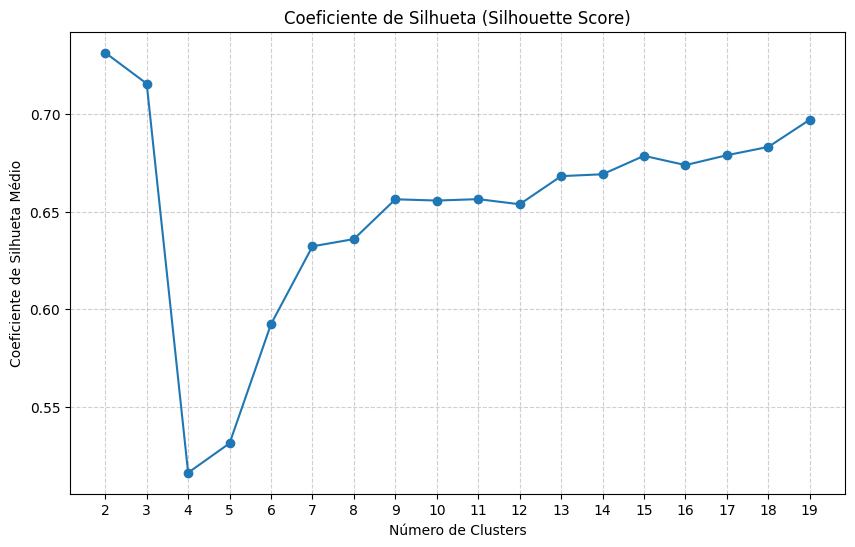

In [164]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters_silhouette, silhouette_scores, marker='o')
plt.title('Coeficiente de Silhueta (Silhouette Score)')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhueta Médio')
plt.xticks(range_n_clusters_silhouette) # Garante que todos os números de clusters testados apareçam no eixo X
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [165]:
def plot_cluster(data, cluster_columns, n_clusters, x_column, y_column, label_column, title, x_label, y_label):

  values = data[cluster_columns]

  kmeans_mca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)  # n_init para evitar warnings
  kmeans_mca.fit(values)

  # Change 1: use values instead of kmeans
  labels = kmeans_mca.labels_
  centroids = kmeans_mca.cluster_centers_

  data['cluster'] = labels

  plt.figure(figsize=(14, 10))  # Tamanho da figura

  # --- Início: Plotagem das Áreas de Decisão (Decision Boundaries) ---
  # Cria um meshgrid para cobrir a área do gráfico
  # Change 2: Access values using .iloc[] for integer-based indexing
  x_min_values, x_max_values = values.iloc[:, 0].min() - 0.1, values.iloc[:, 0].max() + 0.1
  y_min_values, y_max_values = values.iloc[:, 1].min() - 0.1, values.iloc[:, 1].max() + 0.1

  xx_values, yy_values = np.meshgrid(np.arange(x_min_values, x_max_values, 0.01),
                                    np.arange(y_min_values, y_max_values, 0.01))

  # Prediz o cluster para cada ponto no meshgrid
  Z_values = kmeans_mca.predict(np.c_[xx_values.ravel(), yy_values.ravel()])
  Z_values = Z_values.reshape(xx_values.shape)

  cmap_clusters = plt.cm.get_cmap('viridis', n_clusters)

  # Change 3: use xx_values, yy_values, Z_values instead of xx_mca, yy_mca, Z_mca
  plt.contourf(xx_values, yy_values, Z_values, alpha=0.3, cmap=cmap_clusters)

  sns.scatterplot(data=data,
                  x=x_column,
                  y=y_column,
                  hue='cluster',
                  palette=cmap_clusters,
                  s=100,
                  legend='full')

  plt.scatter(centroids[:, 0], centroids[:, 1],
              marker='X',
              s=250,
              color='red',
              label='Centróides dos Clusters',
              edgecolors='black',
              zorder=5)

  for i in range(len(data)):
    plt.text(x=data[x_column].iloc[i] + 0.05, # Posição X do texto (ajuste o offset)
             y=data[y_column].iloc[i] + 0.05, # Posição Y do texto (ajuste o offset)
             s=data[label_column].iloc[i], # O texto a ser exibido
             fontdict=dict(color='black', size=9), # Dicionário para configurar a fonte
             zorder=10)

  plt.title(title)
  plt.xlabel(x_label)
  # Change 4: use y_label instead of t_label
  plt.ylabel(y_label)

  plt.grid(True, linestyle='--', alpha=0.6)

  plt.tight_layout()

  plt.show()

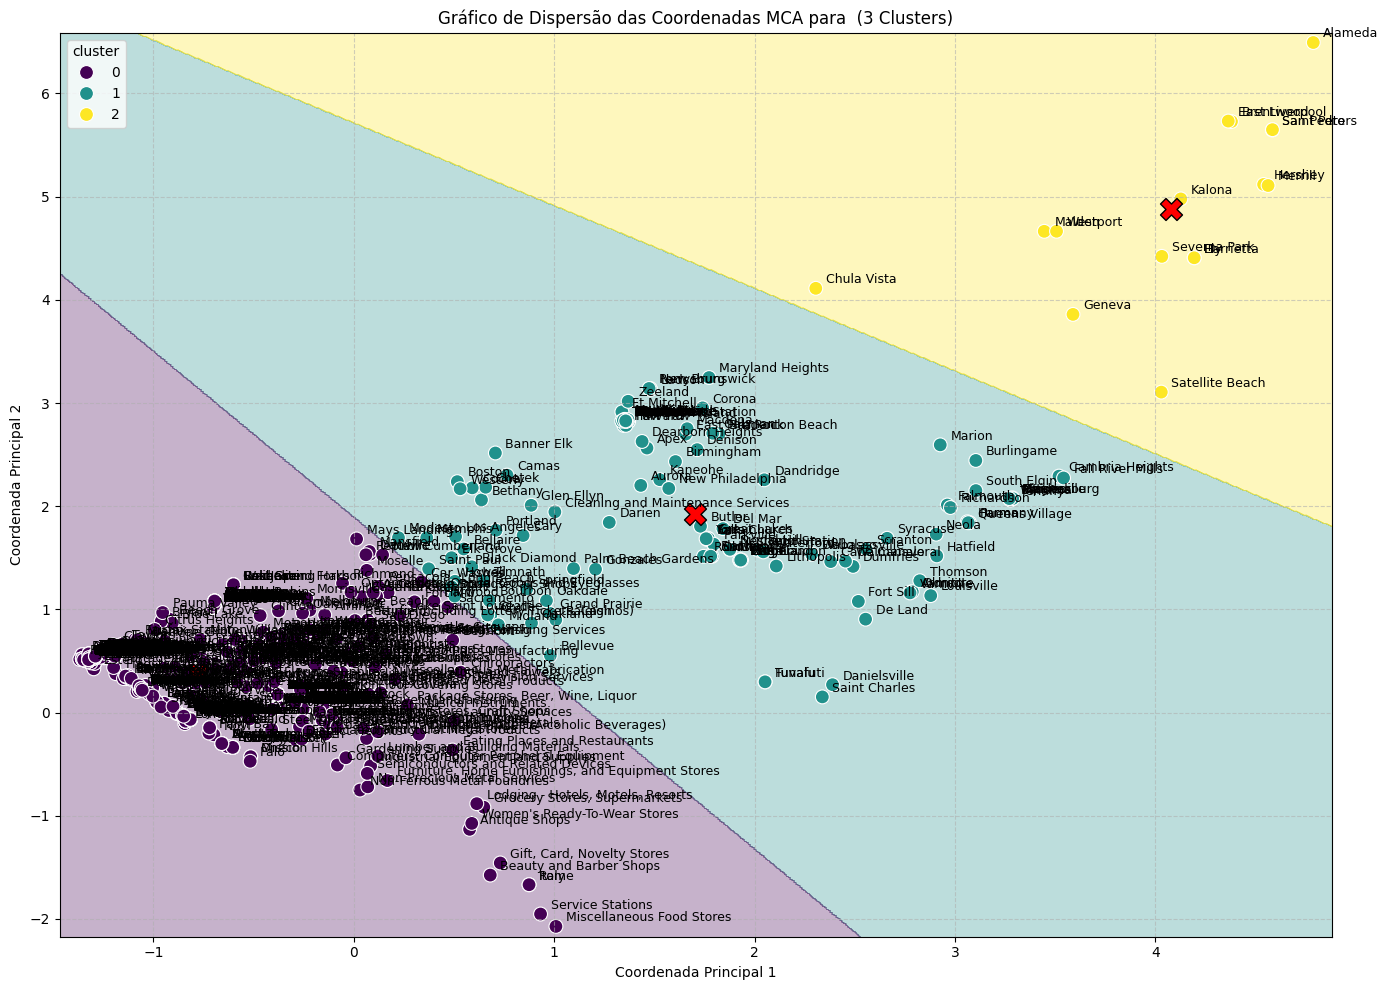

In [166]:
plot_cluster(data=chart_df_mca, cluster_columns=['obs_x', 'obs_y'], n_clusters=3, x_column='obs_x', y_column='obs_y', label_column='categoria_id', title='Gráfico de Dispersão das Coordenadas MCA para  (3 Clusters)', x_label='Coordenada Principal 1', y_label='Coordenada Principal 2')

In [167]:
chart_df_mca['variavel'].value_counts()

variavel
city        729
category     97
country       4
target        1
Name: count, dtype: int64

In [168]:
categorias = chart_df_mca.query('variavel == "category"')
X_mca = categorias[['obs_x', 'obs_y']].values
categorias

categoria     obs_x     obs_y  \
734                              category__Airlines -0.145137  0.945787   
735  category__Amusement Parks, Carnivals, Circuses -0.388487  0.739870   
736                         category__Antique Shops  0.577855 -1.131694   
737     category__Artist Supply Stores, Craft Shops -0.087605 -0.072789   
738    category__Athletic Fields, Commercial Sports -0.401961  0.732027   
..                                              ...       ...       ...   
826                       category__Travel Agencies -0.245692  0.648315   
827         category__Upholstery and Drapery Stores -0.690091  0.419289   
828                        category__Welding Repair -0.144730  0.798305   
829                       category__Wholesale Clubs -0.424719  0.609859   
830          category__Women's Ready-To-Wear Stores  0.588723 -1.073891   

     variavel                          categoria_id  cluster  
734  category                              Airlines        0  
735  category  Amusement Parks, Carnivals, Circuses        0  
736  category                         Antique Shops        0  
737  category     Artist Supply Stores, Craft Shops        0  
738  category    Athletic Fields, Commercial Sports        0  
..        ...                                   ...      ...  
826  category                       Travel Agencies        0  
827  category         Upholstery and Drapery Stores        0  
828  category                        Welding Repair        0  
829  category                       Wholesale Clubs        0  
830  category          Women's Ready-To-Wear Stores        0  

[97 rows x 6 columns]

In [169]:
inertia = []
# Define um intervalo de números de clusters para testar (ex: de 1 a 10)
# Ajuste o range_n_clusters conforme a sua necessidade e o tamanho dos seus dados
range_n_clusters = range(2, 20)

for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    kmeans.fit(X_mca)
    inertia.append(kmeans.inertia_)

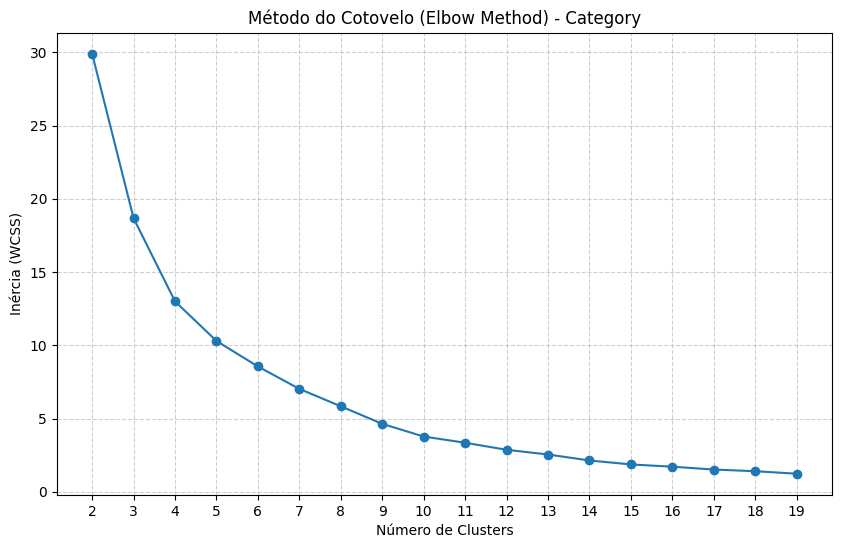

In [170]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Método do Cotovelo (Elbow Method) - Category')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (WCSS)')
plt.xticks(range_n_clusters) # Garante que todos os números de clusters testados apareçam no eixo X
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [171]:
silhouette_scores = []
# Define um intervalo de números de clusters para testar (ex: de 2 a 10)
# Ajuste o range_n_clusters_silhouette conforme a sua necessidade
range_n_clusters_silhouette = range(2, 20)

for n in range_n_clusters_silhouette:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    kmeans.fit(X_mca)
    score = silhouette_score(X_mca, kmeans.labels_) # Calcula o coeficiente de silhueta médio
    silhouette_scores.append(score)

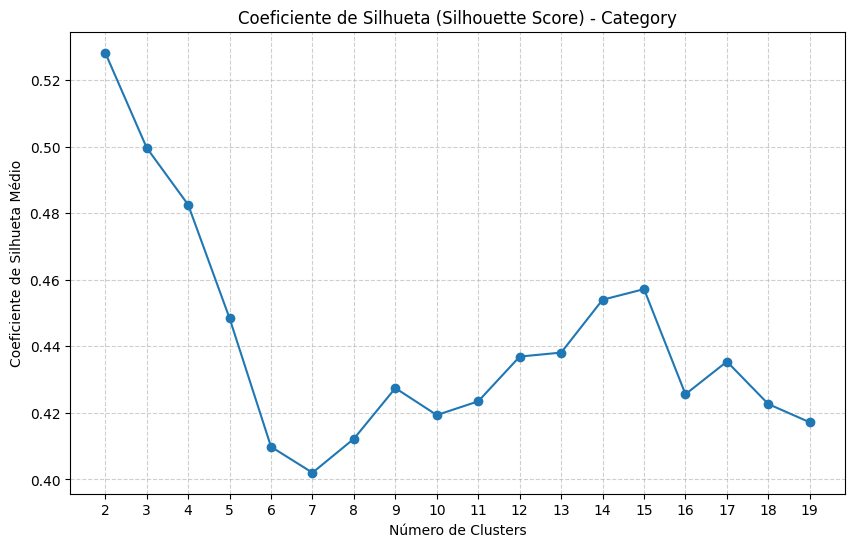

In [172]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters_silhouette, silhouette_scores, marker='o')
plt.title('Coeficiente de Silhueta (Silhouette Score) - Category')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhueta Médio')
plt.xticks(range_n_clusters_silhouette) # Garante que todos os números de clusters testados apareçam no eixo X
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

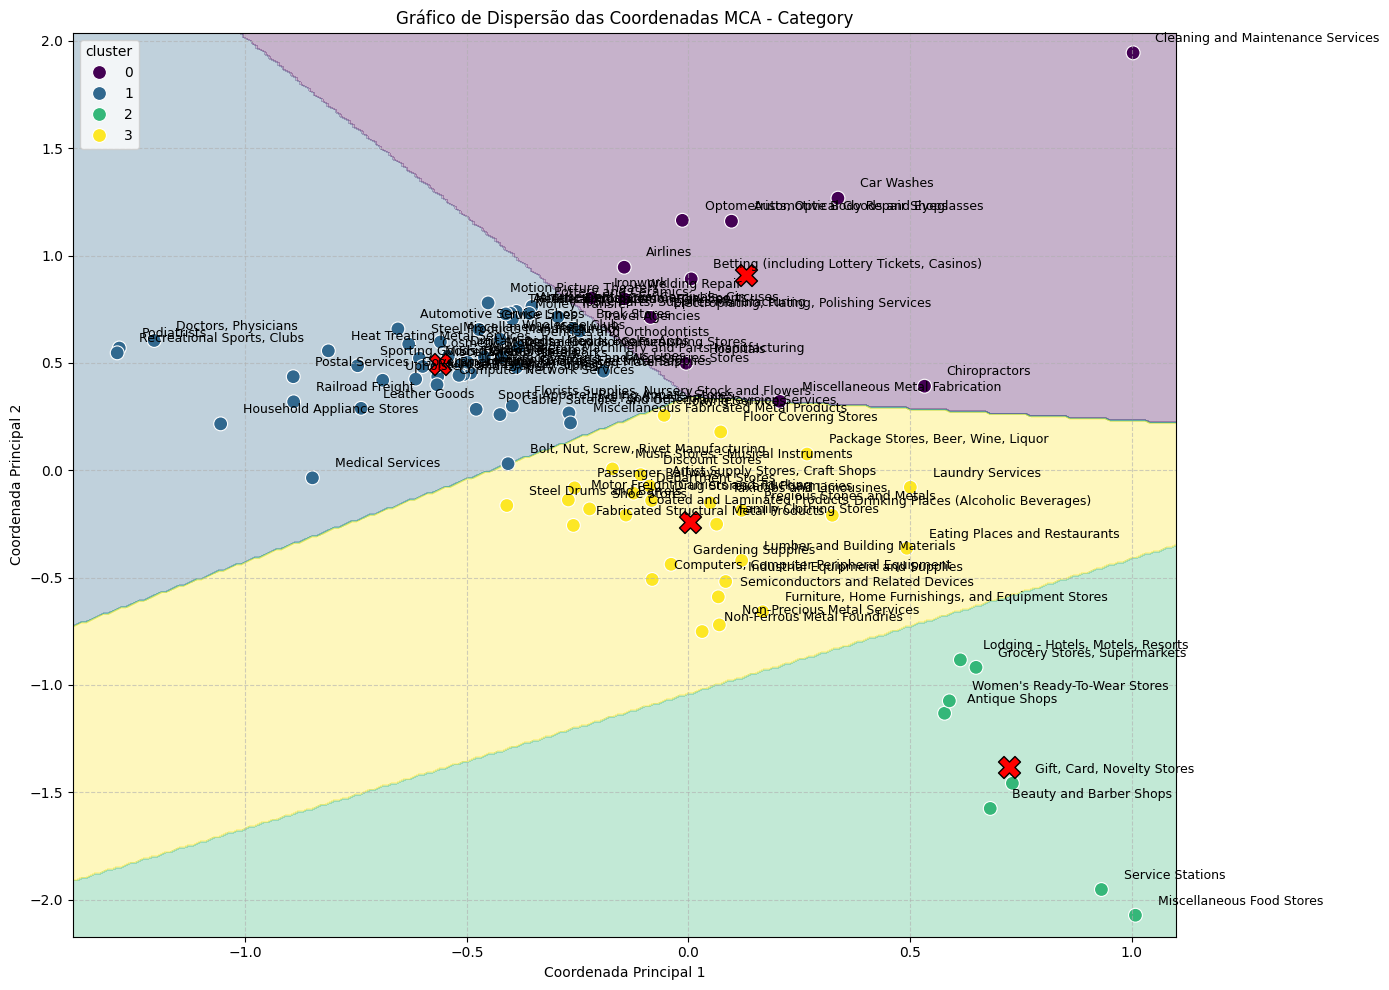

In [173]:
plot_cluster(data=categorias, cluster_columns=['obs_x', 'obs_y'], n_clusters=4, x_column='obs_x', y_column='obs_y', label_column='categoria_id', title='Gráfico de Dispersão das Coordenadas MCA - Category', x_label='Coordenada Principal 1', y_label='Coordenada Principal 2')

In [174]:
cidades = chart_df_mca.query('variavel == "city"')
X_mca = cidades[['obs_x', 'obs_y']].values
cidades

categoria     obs_x     obs_y variavel categoria_id  cluster
1       city__Abilene -1.293251  0.530117     city      Abilene        0
2      city__Abingdon -0.658811 -0.300481     city     Abingdon        0
3           city__Ada -0.697233  1.043100     city          Ada        0
4         city__Adams -1.289242  0.547054     city        Adams        0
5          city__Aiea -0.815949 -0.066303     city         Aiea        0
..                ...       ...       ...      ...          ...      ...
725      city__Yoakum  1.356692  2.826857     city       Yoakum        1
726     city__Yonkers -1.060419  0.231257     city      Yonkers        0
727        city__York  1.758301  1.684941     city         York        1
728  city__Youngstown -0.399364  0.038110     city   Youngstown        0
729     city__Zeeland  1.369096  3.016561     city      Zeeland        1

[729 rows x 6 columns]

In [175]:
inertia = []
# Define um intervalo de números de clusters para testar (ex: de 1 a 10)
# Ajuste o range_n_clusters conforme a sua necessidade e o tamanho dos seus dados
range_n_clusters = range(2, 20)

for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    kmeans.fit(X_mca)
    inertia.append(kmeans.inertia_)

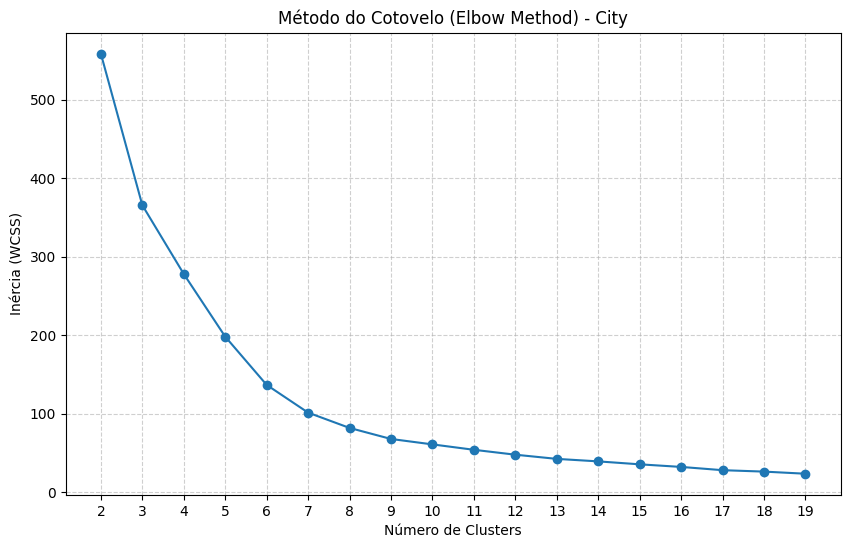

In [176]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Método do Cotovelo (Elbow Method) - City')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (WCSS)')
plt.xticks(range_n_clusters) # Garante que todos os números de clusters testados apareçam no eixo X
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [177]:
silhouette_scores = []
# Define um intervalo de números de clusters para testar (ex: de 2 a 10)
# Ajuste o range_n_clusters_silhouette conforme a sua necessidade
range_n_clusters_silhouette = range(2, 20)

for n in range_n_clusters_silhouette:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    kmeans.fit(X_mca)
    score = silhouette_score(X_mca, kmeans.labels_) # Calcula o coeficiente de silhueta médio
    silhouette_scores.append(score)

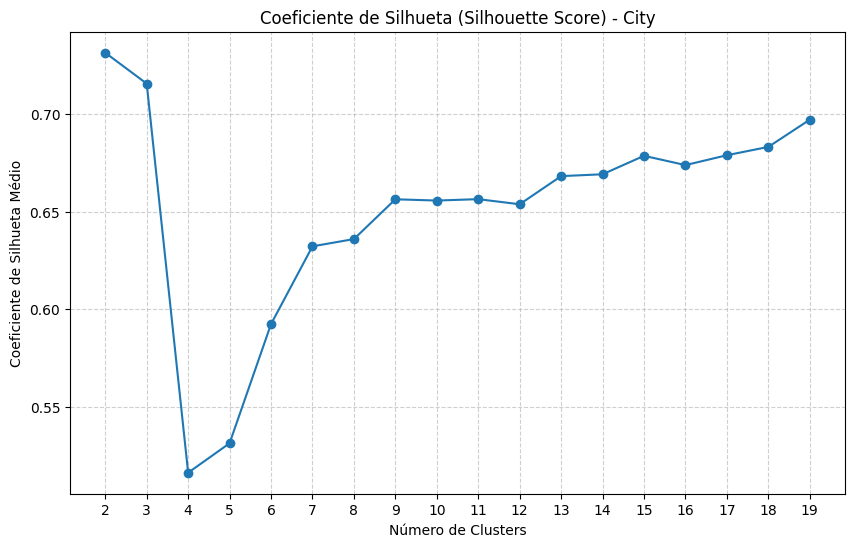

In [178]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters_silhouette, silhouette_scores, marker='o')
plt.title('Coeficiente de Silhueta (Silhouette Score) - City')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhueta Médio')
plt.xticks(range_n_clusters_silhouette) # Garante que todos os números de clusters testados apareçam no eixo X
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

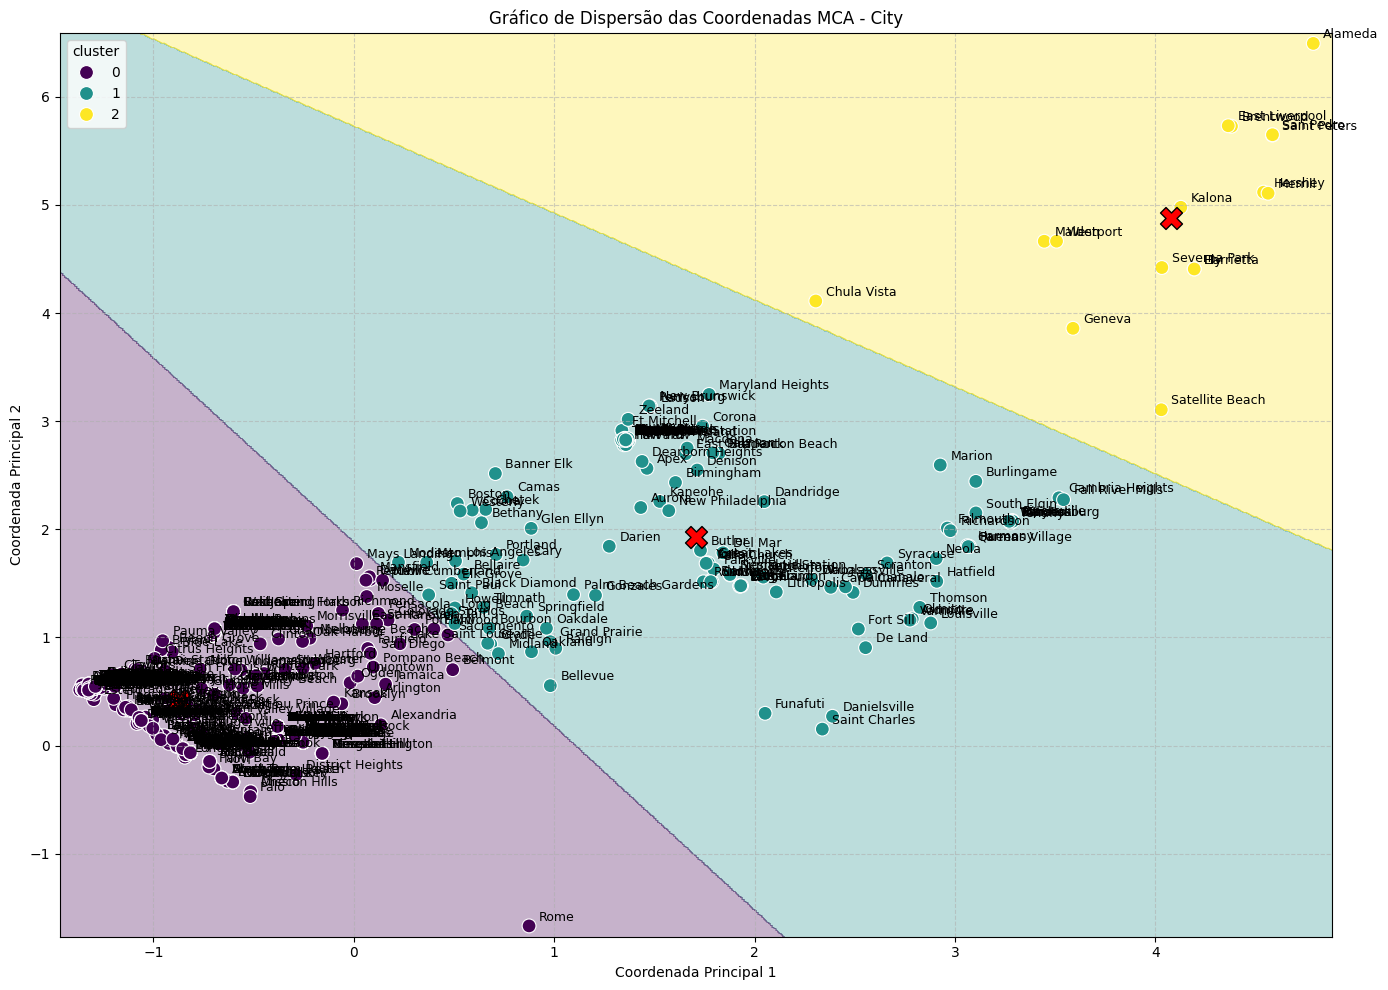

In [179]:
plot_cluster(data=cidades, cluster_columns=['obs_x', 'obs_y'], n_clusters=3, x_column='obs_x', y_column='obs_y', label_column='categoria_id', title='Gráfico de Dispersão das Coordenadas MCA - City', x_label='Coordenada Principal 1', y_label='Coordenada Principal 2')